# **Auto-Insurance Customer Lifetime Value (CLV) Prediction**

## **Background Overview**
Customer Lifetime Value (CLV) quantifies the total revenue a customer generates for a business throughout their engagement. In the insurance sector, this metric is critical due to the industry’s unique risk-pooling model: insurers aggregate risks from policyholders and reinvest collected premiums into income-generating assets (e.g., bonds, Treasury securities). Profitability hinges on two levers:
1. Premium income from clients
2. Investment returns on pooled funds

Insurers use CLV to segment customers and optimise risk-adjusted pricing, as well as to identify high-value customes and tailor retention strategies, directly linking premium stability to profitability. 

## **Business Problems**
The goal of this project is to investigate the pattern present in the existing customers and predict Customer Lifetime Value (CLV) of Auto Insurance Company A to solve these core business problems:
1. **Prioritize High-Value Customers**<br>
    Identify customers with the **highest predictied CLV** to focus retention efforts.
2. **Optimize Marketing Spend**<br>
    Allocate budgets to acquire customers **similar to high-CLV profiles** (e.g., married, multi-policy holders).
3. **Dynamic Pricing & Risk Adjustment**<br>
    Adjust premiums for customers likely to yield **long-term profitability** (e.g., safe drivers with high CLV).

## **Analytical Approach**
To tackle this regression problem, a combination of linear and tree-based models was employed. Linear models such as Ridge, Lasso, and ElasticNet were chosen for their regularization capabilities, which help address multicollinearity and prevent overfitting. Tree-based models—including Random Forest, XGBoost, LightGBM, and Gradient Boosting—were also used due to their ability to model complex nonlinear relationships and handle feature interactions automatically.

Feature engineering played a key role in improving model performance. A log transformation was applied to the target variable to reduce skewness and stabilize variance. Additionally, interaction terms were introduced to capture potential relationships between predictors that linear models might otherwise miss.

Model evaluation was conducted using k-fold cross-validation to ensure robustness. Both baseline and hyperparameter-tuned versions of the models were tested and compared using performance metrics such as MAE, RMSE, R², and MAPE.

## **Metric Evaluation**
Model performance was assessed using multiple evaluation metrics to ensure a well-rounded understanding of predictive accuracy. The primary metrics used were Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), R-squared (R²), and Adjusted R-squared.

MAE and RMSE were used to quantify the average magnitude of prediction errors, with RMSE giving more weight to larger errors. MAPE provided an intuitive percentage-based view of error relative to actual values, which is particularly helpful for comparing performance across different scales. R² measured the proportion of variance explained by the model, while Adjusted R² accounted for the number of predictors, providing a more accurate assessment of goodness-of-fit in models with multiple features.

These metrics were calculated on both baseline and tuned models using cross-validation to ensure generalizability and avoid overfitting. The combination of these metrics allowed for a comprehensive evaluation of each model’s strengths and weaknesses.

## **Data Structure Overview**
Dataset is about customer information of an auto insurance company in the United States. Every row represents information of one customer about their insurance subscription to the auto insurance company.

**Attribute Information**
|Column Name                |Description                                            |Type           |
|:-------------------------:|:-----------------------------------------------------:|:-------------:|
|`Vehicle Class`            |Vehicle Class of each policy holders                   |Categorical    |
|`Coverage`                 |Basic, Extended, Premium                               |Categorical    |
|`Renew Offer Type`         |Offer1, Offer2, Offer3                                 |Categorical    |
|`EmploymentStatus`         |Retired, Employed, Disabled, Medical Leave, Unemployed |Categorical    |
|`Marital Status`           |Single, Married, Divorce                               |Categorical    |
|`Education`                |High School or Below, College, Bachelor, Master, Doctor|Categorical    |
|`Number of Policies`       |Policies held                                          |Float          |
|`Monthly Premium Auto`     |Reccuring revenue per customer                         |Float          |
|`Total Claim Amount`       |Historical claims cost per customer                    |Float          |
|`Income`                   |Annual income per customer                             |Float          |
|`Customer Lifetime Value`  |Net profit from the customer over the period of time   |Float          |

## **Import Necessary Libraries**

In [ ]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

from scipy.stats import f_oneway, boxcox, probplot, skew, kstest

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, cross_val_predict, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

In [2]:
sns.set_theme(style = 'ticks', palette = 'deep')

## **Import Dataset**

In [164]:
df = pd.read_csv('data_customer_lifetime_value.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5669 entries, 0 to 5668
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Vehicle Class            5669 non-null   object 
 1   Coverage                 5669 non-null   object 
 2   Renew Offer Type         5669 non-null   object 
 3   EmploymentStatus         5669 non-null   object 
 4   Marital Status           5669 non-null   object 
 5   Education                5669 non-null   object 
 6   Number of Policies       5669 non-null   float64
 7   Monthly Premium Auto     5669 non-null   float64
 8   Total Claim Amount       5669 non-null   float64
 9   Income                   5669 non-null   float64
 10  Customer Lifetime Value  5669 non-null   float64
dtypes: float64(5), object(6)
memory usage: 487.3+ KB


In [165]:
df.apply(pd.Series.unique).reset_index(drop=False)

,index,0
0,Vehicle Class,"[Four-Door Car, Two-Door Car, SUV, Sports Car,..."
1,Coverage,"[Extended, Basic, Premium]"
2,Renew Offer Type,"[Offer1, Offer3, Offer2, Offer4]"
3,EmploymentStatus,"[Retired, Employed, Disabled, Medical Leave, U..."
4,Marital Status,"[Divorced, Married, Single]"
5,Education,"[High School or Below, College, Master, Bachel..."
6,Number of Policies,"[2.0, 6.0, 1.0, 8.0, 5.0, 3.0, 7.0, 4.0, 9.0]"
7,Monthly Premium Auto,"[90.0, 62.0, 116.0, 107.0, 101.0, 66.0, 65.0, ..."
8,Total Claim Amount,"[571.479602, 114.51444, 257.248789, 556.8, 355..."
9,Income,"[11828.0, 44762.0, 21514.0, 17913.0, 19030.0, ..."


In [166]:
df.isnull().sum()

Vehicle Class              0
Coverage                   0
Renew Offer Type           0
EmploymentStatus           0
Marital Status             0
Education                  0
Number of Policies         0
Monthly Premium Auto       0
Total Claim Amount         0
Income                     0
Customer Lifetime Value    0
dtype: int64

<Axes: >

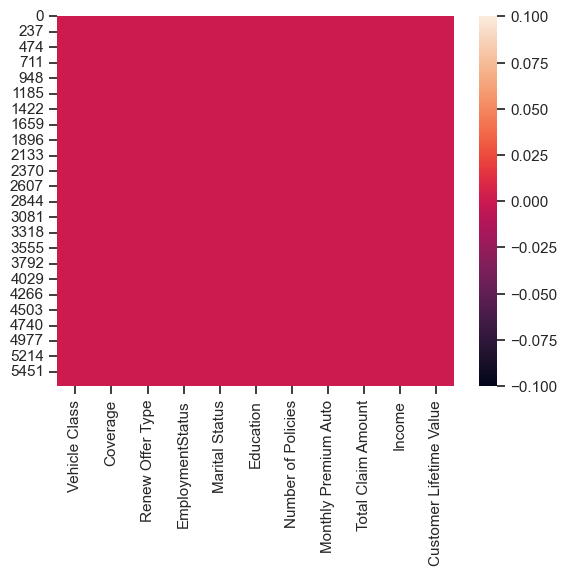

In [167]:
sns.heatmap(df.isna())

In [168]:
df.duplicated(subset="Customer Lifetime Value", keep = "first").sum()

np.int64(620)

In [169]:
duplicated_data = df[df.duplicated(subset="Customer Lifetime Value", keep = "first")]
duplicated_data

,Vehicle Class,Coverage,Renew Offer Type,EmploymentStatus,Marital Status,Education,Number of Policies,Monthly Premium Auto,Total Claim Amount,Income,Customer Lifetime Value
188,Sports Car,Basic,Offer2,Unemployed,Married,High School or Below,3.0,119.0,571.200000,0.0,9048.983447
256,Four-Door Car,Basic,Offer1,Retired,Single,Bachelor,1.0,63.0,347.857619,24910.0,2248.449633
331,SUV,Basic,Offer2,Employed,Single,Master,1.0,107.0,513.600000,29462.0,4170.687348
362,SUV,Basic,Offer2,Unemployed,Married,Bachelor,1.0,102.0,660.430456,0.0,3567.503755
366,SUV,Extended,Offer1,Unemployed,Single,College,2.0,126.0,604.800000,0.0,13727.799720
...,...,...,...,...,...,...,...,...,...,...,...
5624,Luxury SUV,Premium,Offer1,Retired,Married,Bachelor,1.0,271.0,1300.800000,14290.0,10179.717040
5640,SUV,Extended,Offer2,Unemployed,Married,College,1.0,122.0,725.870693,0.0,4270.034394
5642,Four-Door Car,Extended,Offer2,Employed,Married,College,1.0,95.0,281.110788,93272.0,3861.486269
5654,Four-Door Car,Extended,Offer2,Employed,Married,College,8.0,82.0,393.600000,72608.0,6521.368813


In [170]:
df = df.drop_duplicates(subset='Customer Lifetime Value', keep='first')

## **Skimming the Dataset**

### **`Vehicle Class`**

In [171]:
df['Vehicle Class'].unique()

array(['Four-Door Car', 'Two-Door Car', 'SUV', 'Sports Car', 'Luxury SUV',
       'Luxury Car'], dtype=object)

In [172]:
df['Vehicle Class'].value_counts(normalize = True, ascending = False, dropna = False).mul(100).round(2)

Vehicle Class
Four-Door Car    50.80
Two-Door Car     20.95
SUV              19.07
Sports Car        5.19
Luxury SUV        2.00
Luxury Car        1.98
Name: proportion, dtype: float64

### **`Coverage`**

In [173]:
df['Coverage'].unique()

array(['Extended', 'Basic', 'Premium'], dtype=object)

In [174]:
df['Coverage'].value_counts(normalize = True, ascending = False, dropna = False).mul(100).round(2)

Coverage
Basic       61.38
Extended    30.05
Premium      8.58
Name: proportion, dtype: float64

### **`Renew Offer Type`**

In [175]:
df['Renew Offer Type'].unique()

array(['Offer1', 'Offer3', 'Offer2', 'Offer4'], dtype=object)

In [176]:
df['Renew Offer Type'].value_counts(normalize = True, ascending = False, dropna = False).mul(100).round(2)

Renew Offer Type
Offer1    39.99
Offer2    29.81
Offer3    17.49
Offer4    12.72
Name: proportion, dtype: float64

### **`EmploymentStatus`**

In [177]:
df['EmploymentStatus'].unique()

array(['Retired', 'Employed', 'Disabled', 'Medical Leave', 'Unemployed'],
      dtype=object)

In [178]:
df['EmploymentStatus'].value_counts(normalize = True, ascending = False, dropna = False).mul(100).round(2)

EmploymentStatus
Employed         63.12
Unemployed       26.34
Medical Leave     4.59
Disabled          4.28
Retired           1.66
Name: proportion, dtype: float64

### **`Marital Status`**

In [179]:
df['Marital Status'].unique()

array(['Divorced', 'Married', 'Single'], dtype=object)

In [180]:
df['Marital Status'].value_counts(normalize = True, ascending = False, dropna = False).mul(100).round(2)

Marital Status
Married     59.14
Single      27.17
Divorced    13.69
Name: proportion, dtype: float64

### **`Education`**

In [181]:
df['Education'].unique()

array(['High School or Below', 'College', 'Master', 'Bachelor', 'Doctor'],
      dtype=object)

In [182]:
df['Education'].value_counts(normalize = True, ascending = False, dropna = False).mul(100).round(2)

Education
Bachelor                30.28
College                 29.17
High School or Below    28.70
Master                   7.86
Doctor                   3.98
Name: proportion, dtype: float64

### **`Number of Policies`**

In [183]:
df['Number of Policies'].unique()

array([2., 6., 1., 8., 5., 3., 7., 4., 9.])

In [184]:
df['Number of Policies'].value_counts(normalize = True, ascending = False, dropna = False).mul(100).round(2)

Number of Policies
1.0    34.88
2.0    24.96
3.0    13.05
5.0     4.79
7.0     4.77
4.0     4.58
9.0     4.52
6.0     4.32
8.0     4.14
Name: proportion, dtype: float64

### **`Monthly Premium Auto`**

In [185]:
df['Monthly Premium Auto'].unique()

array([ 90.,  62., 116., 107., 101.,  66.,  65., 117.,  78.,  63.,  70.,
        71.,  61.,  64., 129., 100.,  68., 126.,  95., 128.,  84., 125.,
        98.,  97., 121., 192.,  69.,  83.,  72.,  67., 103.,  74.,  89.,
        86., 110., 124.,  73., 191., 122., 133., 165., 127., 144., 114.,
       194., 118., 111., 138., 119.,  76.,  80., 154., 189., 130., 109.,
       161.,  88.,  93., 113.,  87., 136., 106.,  99., 105.,  82.,  96.,
       159., 181., 146., 115., 187., 108., 209., 102., 104.,  77.,  79.,
       283., 150.,  92.,  91., 180., 131., 112., 184., 137., 185.,  94.,
       198., 135., 140., 132., 139.,  85., 123., 214., 201., 155., 193.,
        81., 223., 188., 134., 153., 147., 202., 196., 167., 175., 199.,
       183., 217., 247., 287., 176., 271., 172., 152., 204., 157., 231.,
       143., 203., 285., 156., 249., 158., 197., 190., 186., 229., 238.,
       173., 222., 182., 239., 141., 245., 178., 168., 240., 248., 210.,
       171., 207., 213., 230., 215., 179., 145., 22

In [186]:
df['Monthly Premium Auto'].value_counts(normalize = True, ascending = False, dropna = False).mul(100).round(2)

Monthly Premium Auto
65.0     3.53
71.0     3.53
67.0     3.29
69.0     3.25
61.0     3.25
         ... 
284.0    0.02
164.0    0.02
297.0    0.02
177.0    0.02
296.0    0.02
Name: proportion, Length: 191, dtype: float64

### **`Total Claim Amount`**

In [187]:
df['Total Claim Amount'].unique()

array([571.479602, 114.51444 , 257.248789, ..., 446.08476 ,  44.780402,
       161.61574 ])

In [188]:
df['Total Claim Amount'].value_counts(normalize = True, ascending = False, dropna = False).mul(100).round(2)

Total Claim Amount
292.800000    1.19
316.800000    1.09
321.600000    1.07
331.200000    1.07
345.600000    1.05
              ... 
350.650080    0.02
51.961915     0.02
142.567008    0.02
423.787608    0.02
85.063708     0.02
Name: proportion, Length: 3272, dtype: float64

### **`Income`**

In [189]:
df['Income'].unique()

array([11828., 44762., 21514., ..., 27778., 84658., 60184.])

In [190]:
df['Income'].value_counts(normalize = True, ascending = False, dropna = False).mul(100).round(2)

Income
0.0        26.34
28919.0     0.06
80590.0     0.06
79189.0     0.06
28519.0     0.06
           ...  
22538.0     0.02
31614.0     0.02
78358.0     0.02
36510.0     0.02
26477.0     0.02
Name: proportion, Length: 3625, dtype: float64

## **Exploratory Data Analysis**

### **Target Variable Analysis**
Goal is to understand the distribution and outliers in `Customer Lifetime Value`

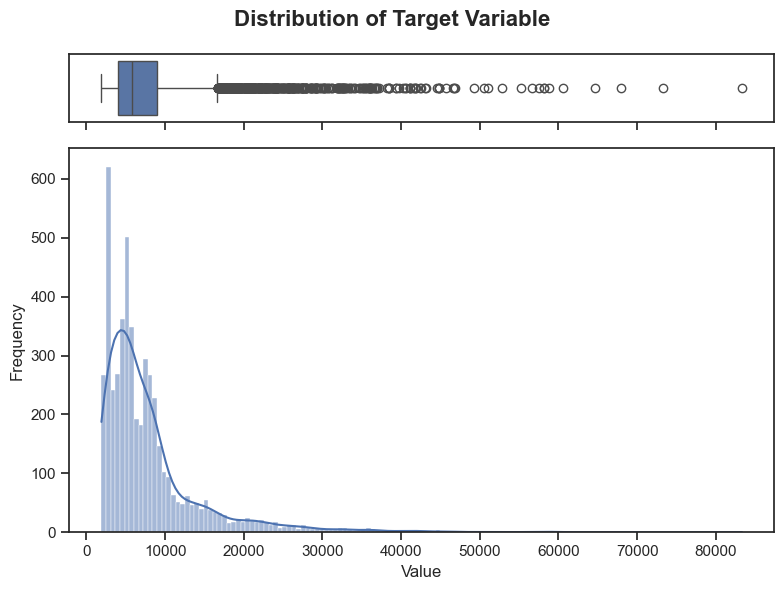

In [191]:
# Create a figure with two subplots (stacked vertically)
fig, (ax_box, ax_hist) = plt.subplots(2, 1, sharex = True, gridspec_kw = {'height_ratios': (0.15, 0.85)}, figsize = (8, 6))

sns.boxplot(data = df, x = 'Customer Lifetime Value', ax = ax_box)
ax_box.set(xlabel = '')
ax_box.set_yticks([])

sns.histplot(data = df, x = 'Customer Lifetime Value', ax = ax_hist, kde = True)
ax_hist.set(xlabel = 'Value', ylabel = 'Frequency')

plt.suptitle('Distribution of Target Variable', fontsize = 16, fontweight = 'bold')
plt.tight_layout()
plt.show()

In [192]:
df['Customer Lifetime Value'].describe()

count     5049.000000
mean      8060.435309
std       6990.074953
min       1898.007675
25%       3964.730745
50%       5837.528088
75%       9028.307862
max      83325.381190
Name: Customer Lifetime Value, dtype: float64

In [193]:
# median vs mean difference
df['Customer Lifetime Value'].mean() - df['Customer Lifetime Value'].median()

np.float64(2222.907220838186)

Based on the distribution of the **target variable**, we can see it is has right-skewed distribution and outliers are also present. This can be confirmed from the difference of **target variable's mean** and **median** where the **mean** is **larger** than the **median**, and the long tail to the right. The outliers can also be confirmed by seeing the **max** of the values which is *10 times* larger than the **75th percentile**. To handle the skewness and outlier, several transformations will be applied to normalize the target variable and also to reduce its impacts on regression models.

### **Categorical Features vs. `Customer Lifetime Value`**
Goal is to identify high-CLV segments.

In [194]:
categorical_features = ['Vehicle Class', 'Coverage', 'Renew Offer Type', 'EmploymentStatus', 'Marital Status', 'Education']

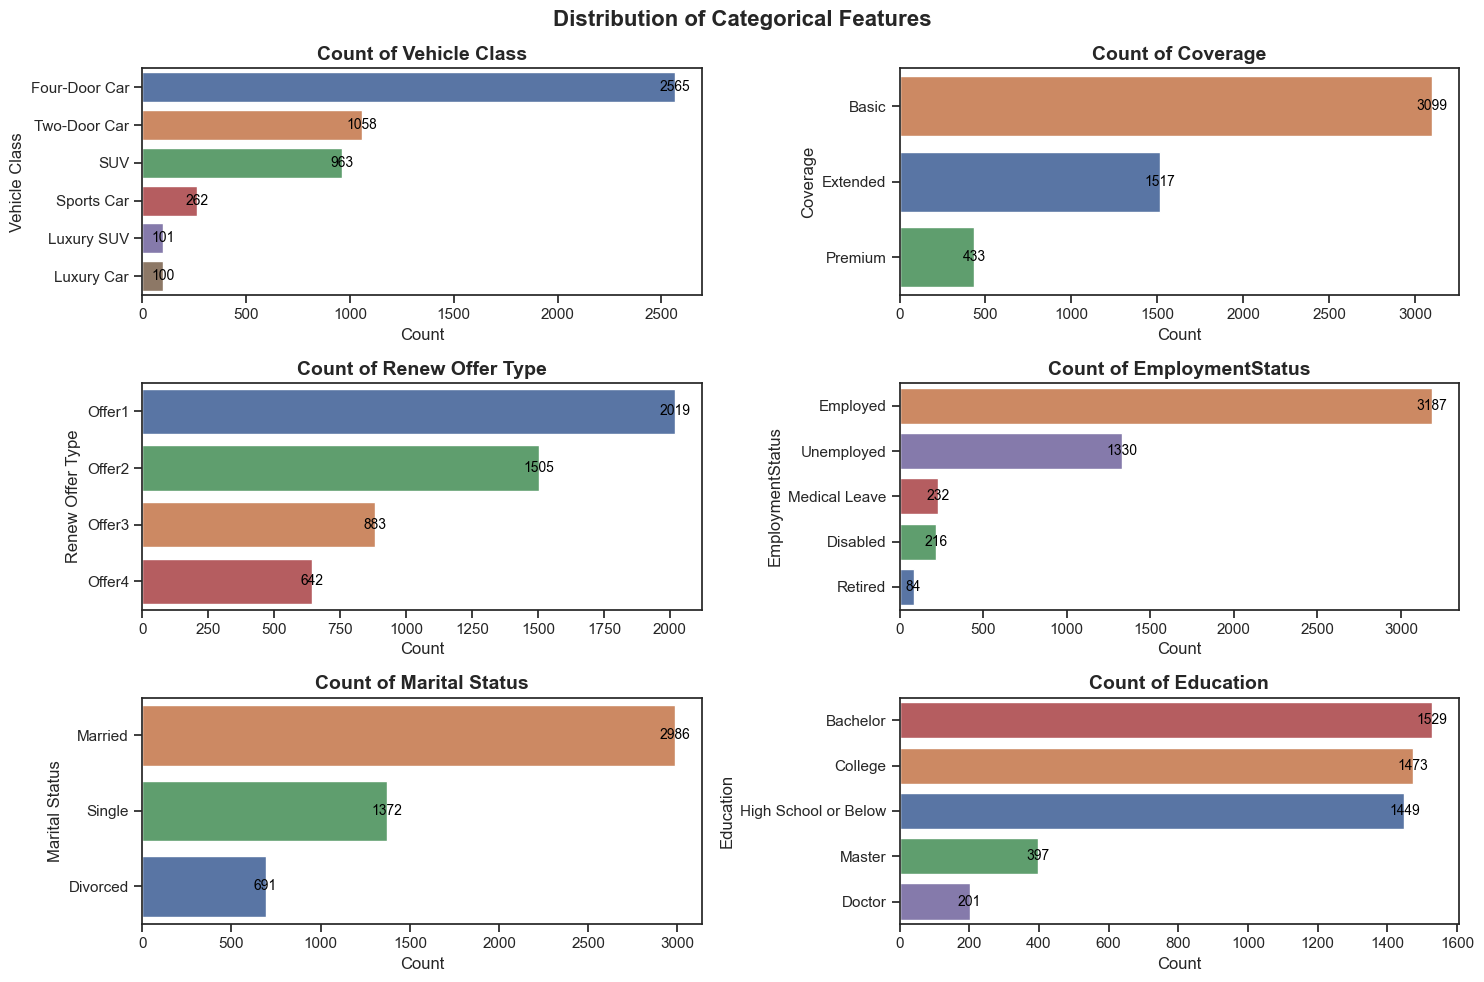

In [195]:
plt.figure(figsize = (15, 10))
num_subplot = 1

for feature in categorical_features:
    plt.subplot(3, 2, num_subplot)
    ax = sns.countplot(data = df, y = feature, order = df[feature].value_counts().index, hue = feature, legend = False)

    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{width:.0f}', (width, p.get_y() + p.get_height() / 2), ha = 'center', va = 'center', 
                    fontsize = 10, color = 'black')

    plt.title(f'Count of {feature}', fontsize = 14, fontweight = 'bold')
    plt.xlabel('Count', fontsize = 12)
    plt.ylabel(feature, fontsize = 12)
    plt.tight_layout()
    num_subplot += 1

plt.suptitle('Distribution of Categorical Features', fontsize = 16, fontweight = 'bold')
plt.tight_layout()
plt.show()

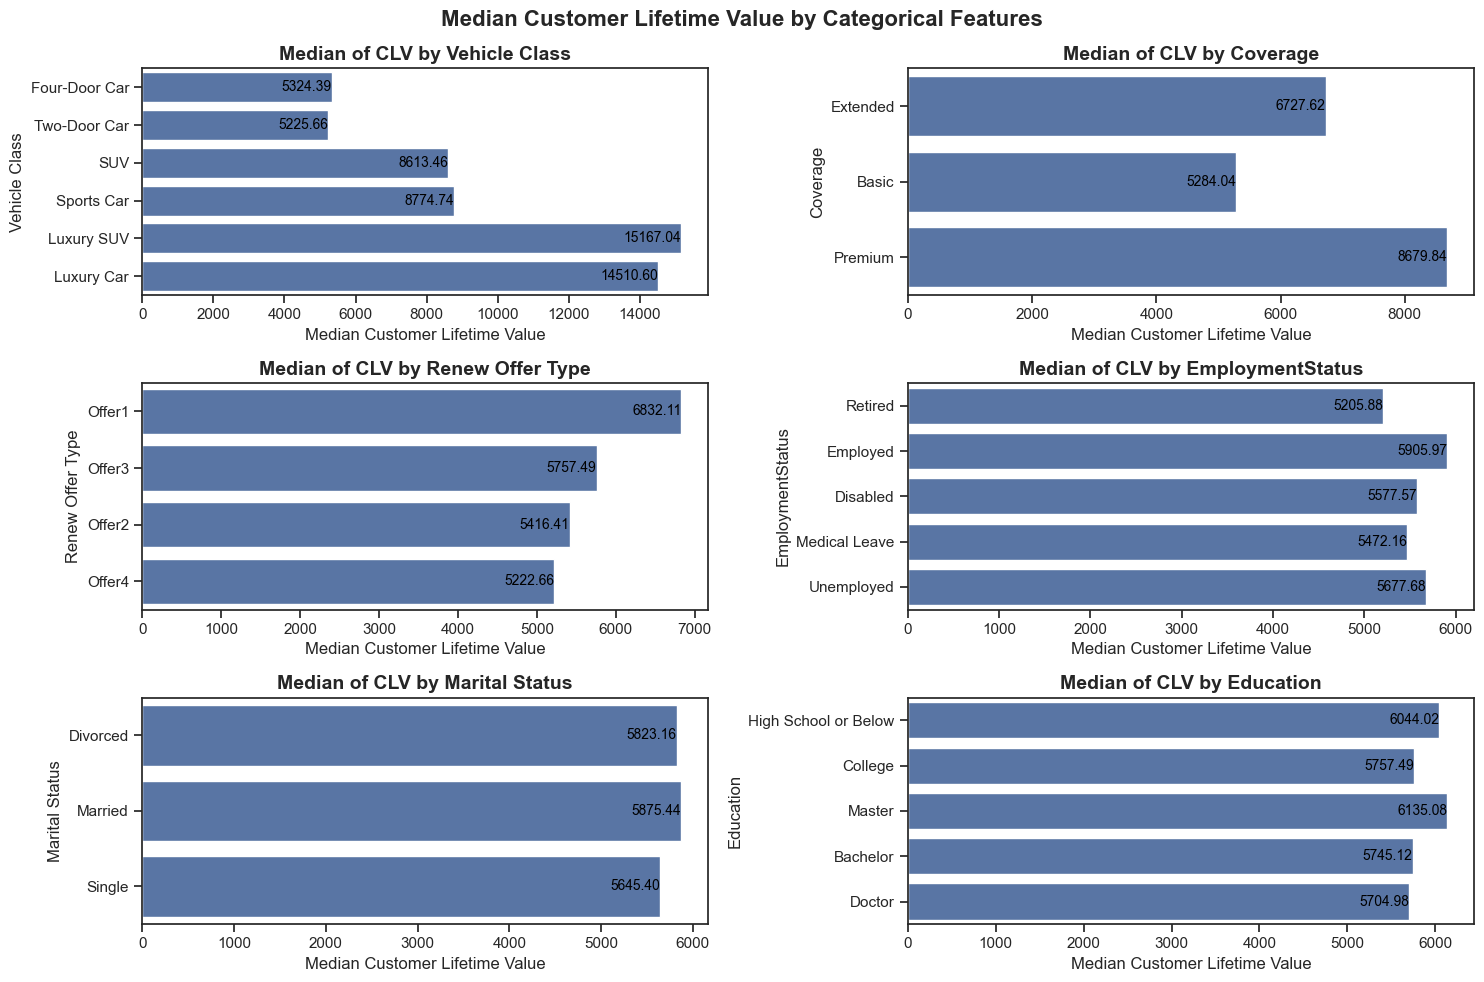

In [196]:
plt.figure(figsize = (15, 10))
num_subplot = 1

for feature in categorical_features:
    plt.subplot(3, 2, num_subplot)
    ax = sns.barplot(data = df, x = 'Customer Lifetime Value', y = feature, estimator = 'median', legend = False, errorbar = None)

    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{width:.2f}', (width, p.get_y() + p.get_height() / 2), ha = 'right', va = 'center', 
                    fontsize = 10, color = 'black')

    plt.title(f'Median of CLV by {feature}', fontsize = 14, fontweight = 'bold')
    plt.xlabel('Median Customer Lifetime Value', fontsize = 12)
    plt.ylabel(feature, fontsize = 12)
    plt.tight_layout()
    num_subplot += 1

plt.suptitle('Median Customer Lifetime Value by Categorical Features', fontsize = 16, fontweight = 'bold')
plt.tight_layout()
plt.show()

In [197]:
# ANOVA for Categorical Variables
anova_results = pd.DataFrame(columns = ['Feature', 'F-Statistic', 'p-value'])

for feature in categorical_features:
    groups = df.groupby(feature)['Customer Lifetime Value'].apply(list)
    f_stat, p_val = f_oneway(*groups)

    anova_results = pd.concat([
        anova_results,
        pd.DataFrame({'Feature': [feature], 'F-Statistic': [f_stat], 'p-value': [p_val]})
    ], ignore_index = True)

anova_results.sort_values(by = 'p-value', inplace = True)
anova_results

C:\Users\Dell\AppData\Local\Temp\ipykernel_37820\1145378117.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  anova_results = pd.concat([


,Feature,F-Statistic,p-value
0,Vehicle Class,165.867934,9.516965e-164
1,Coverage,85.822038,2.227738e-37
2,Renew Offer Type,14.029682,4.174919e-09
5,Education,2.886050,2.118121e-02
3,EmploymentStatus,2.488475,4.134614e-02
4,Marital Status,0.275556,7.591617e-01


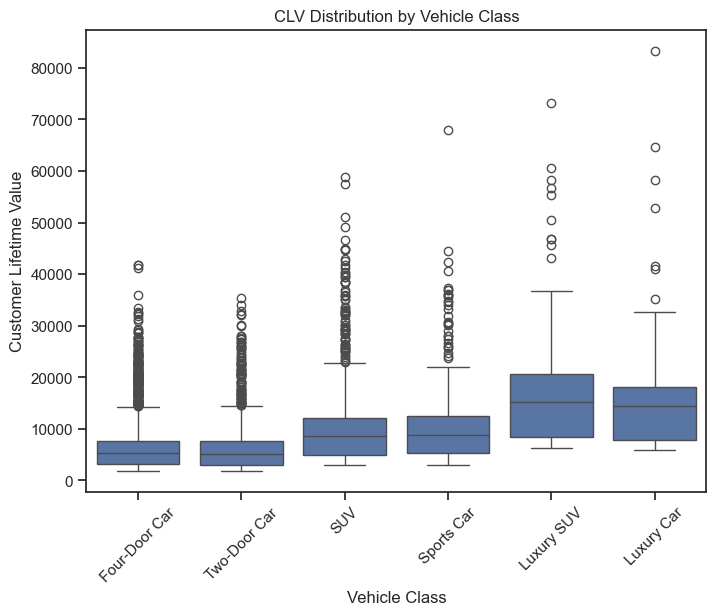

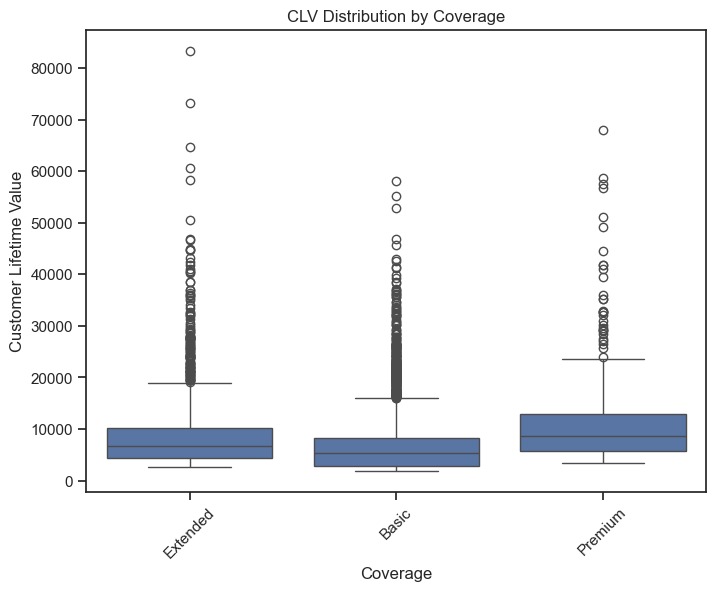

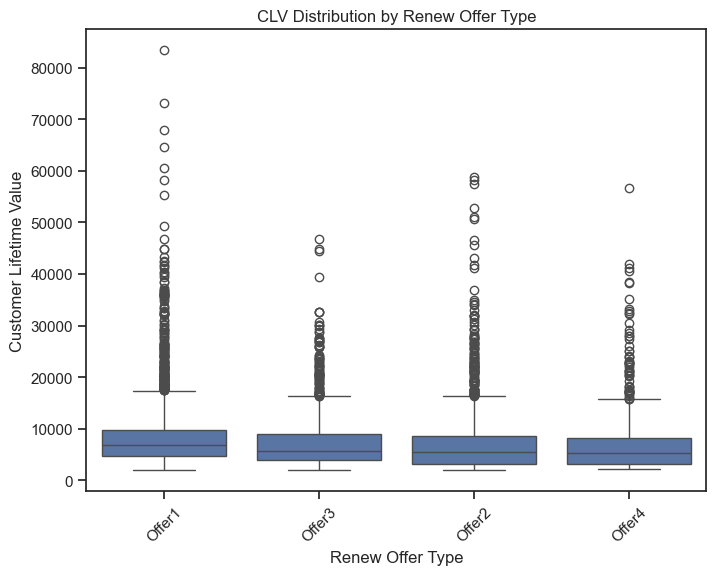

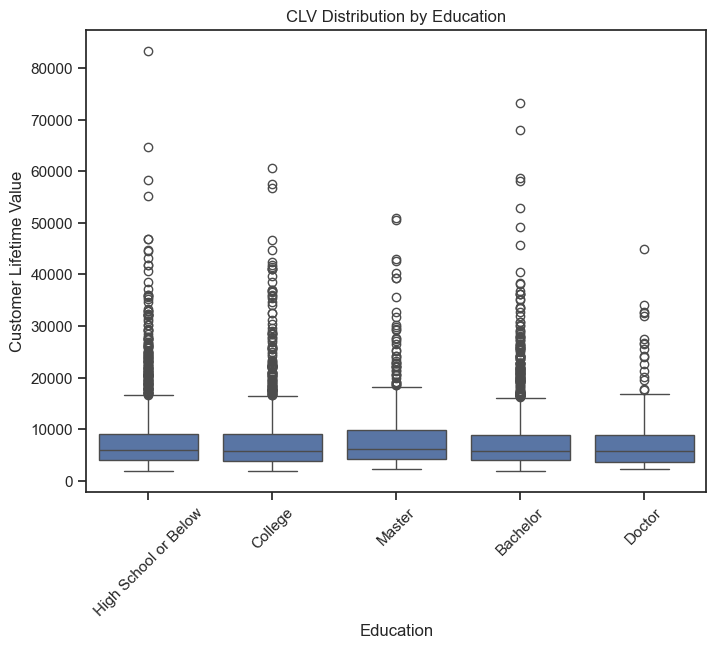

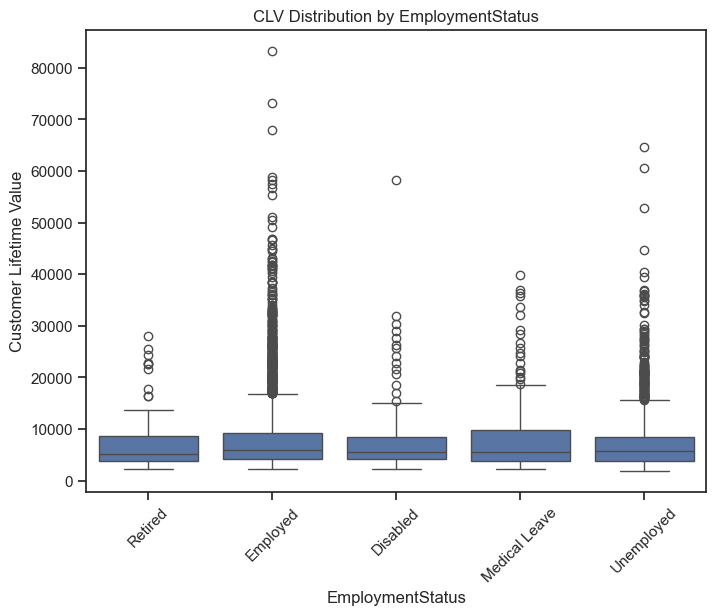

In [198]:
significant_features = anova_results[anova_results['p-value'] < 0.05]['Feature']

for feature in significant_features:
    plt.figure(figsize=(8, 6))
    sns.boxplot(data=df, x=feature, y='Customer Lifetime Value')
    plt.title(f'CLV Distribution by {feature}')
    plt.xticks(rotation=45)
    plt.show()

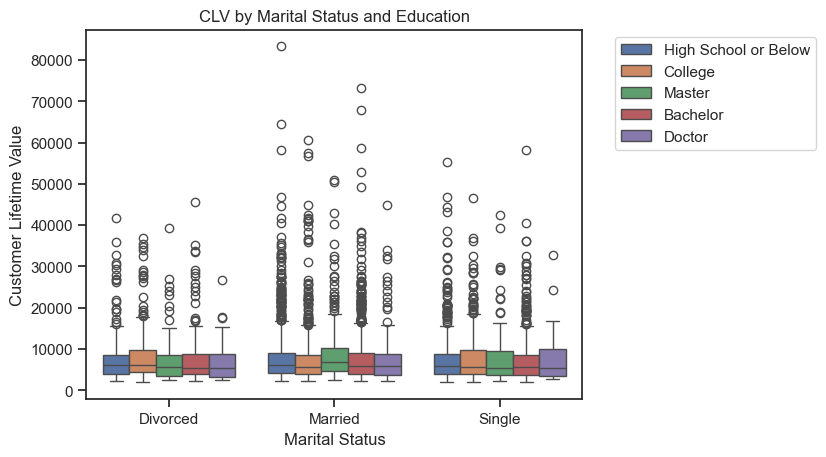

In [199]:
sns.boxplot(
    data=df, 
    x='Marital Status', 
    y='Customer Lifetime Value', 
    hue='Education'
)

plt.title('CLV by Marital Status and Education')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

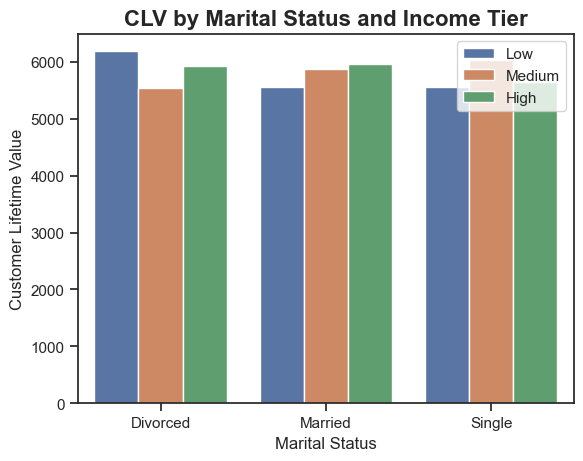

In [200]:
df['Income_Binned'] = pd.qcut(df['Income'], q=3, labels=['Low', 'Medium', 'High'])
sns.barplot(
    data=df, 
    x='Marital Status', 
    y='Customer Lifetime Value', 
    hue='Income_Binned',
    estimator='median',
    errorbar = None
)

plt.legend(loc = 'best')
plt.title('CLV by Marital Status and Income Tier', fontsize = 16, fontweight = 'bold')
plt.show()

In [201]:
df.groupby('Vehicle Class')[['Monthly Premium Auto', 'Total Claim Amount', 'Customer Lifetime Value']].agg(['mean']).reset_index()

,Vehicle Class,Monthly Premium Auto,Total Claim Amount,Customer Lifetime Value
,,mean,mean,mean
0,Four-Door Car,77.020663,346.106756,6617.086575
1,Luxury Car,207.310000,1095.529039,16610.562619
2,Luxury SUV,209.386139,1059.876385,18587.427902
3,SUV,120.860852,573.174610,10501.784338
4,Sports Car,122.190840,550.563401,11543.506772
5,Two-Door Car,76.684310,347.827777,6661.916104


In [202]:
df.groupby('Education')[['Income','Monthly Premium Auto', 'Total Claim Amount', 'Customer Lifetime Value']].agg(['mean']).reset_index()

,Education,Income,Monthly Premium Auto,Total Claim Amount,Customer Lifetime Value
,,mean,mean,mean,mean
0,Bachelor,37495.249182,91.604971,419.125923,7888.610095
1,College,37079.505771,92.973523,422.585934,7772.506603
2,Doctor,44608.009950,91.935323,335.697290,8002.516425
3,High School or Below,35557.419600,93.912353,487.028437,8299.372856
4,Master,45810.239295,94.206549,332.717430,8947.742425


In [203]:
df.groupby('EmploymentStatus')[['Monthly Premium Auto', 'Total Claim Amount', 'Customer Lifetime Value']].agg(['mean']).reset_index()

,EmploymentStatus,Monthly Premium Auto,Total Claim Amount,Customer Lifetime Value
,,mean,mean,mean
0,Disabled,94.185185,467.960741,7556.436601
1,Employed,92.649827,352.166793,8279.478619
2,Medical Leave,91.245690,452.131498,8198.791327
3,Retired,91.345238,487.347456,7542.640812
4,Unemployed,93.617293,600.987981,7625.975784


Based on the ANOVA results, we know that
1. `Vehicle Class`<br>
    **F-Statistic**: 171.19 | **p-value**: ~0.0
    - **Extremely significant** differences in CLV exists across vehicle classes.
    - Luxury cars and Luxury SUVs have **higher CLV** (due to higher monthly premiums), while sports cars have lower CLV than both luxury cars and luxury SUVs (higher risk).
2. `Coverage`<br>
    **F-Statistic**: 91.21 | **p-value**: ~0.0
    - Coverage type (Basic/Extended/Premium) **strongly impacts** CLV.
    - Premium covarage customer likely yield **higher CLV** (more revenue, lower churn)
3. `Renew Offer Type`<br>
    **F-Statistic**: 19.58 | **p-value**: 1.27e-12
    - Renewal offers (e.g., discounts, loyalty rewards) **significantly affect** CLV.
    - Discounts may retain price-sensitive customers, while loyalty rewards might boost long-term value.
4. `Education`<br>
    **F-Statistic**: 3.49 | **p-value**: 0.007
    - **Weak but significant** effect. Master's/Bachelor's holders may have slightly higher CLV (due to higher income or risk aversion).
5. `EmploymentStatus`<br>
    **F-Statistic**: 1.97 | **p-value**: 0.096
    - **Not statistically significant** (p > 0.05), but marginal signal.
6. `Marital Status`<br>
    **F-Statistic**: 0.80 | **p-value**: 0.45
    - No significant impact on CLV. Married/single customers behave similarly.

Knowing that `Marital Status` is not statistically significant, it is necessary if any interaction effects exists. The observations and conclusions are as below:
1. **General Distribution of CLV Across Marital Status**:
    - **Divorced**: The median CLV appears to be the lowest among the three marital statuses, with most values clustering below 40,000. The spread is relatively narrow, indicating less variability.
    - **Married**: The median CLV is higher than **Divorced**, with a broader spread and some outliers reaching up to 70,000 - 80,000. This suggests greater variability and potentially higher-value customers in this group.
    - **Single**: The median CLV is also higher than **Divorced**, with a similar spread to **Married**, including outliers up to 70,000 - 80,000. This indicates a comparable level of variability and potential for high-value customers.
2. **Effect of Education Level**:
    - **High School or Below (Blue)**: Across all marital statuses, this group tends to have the lowest median CLV, often below 20,000–30,000, with a tight interquartile range (IQR) and fewer outliers, suggesting lower and more consistent customer value.
    - **College (Orange)**: This group shows a moderate increase in median CLV compared to High School or Below, with a slightly wider IQR and some outliers, particularly for Married and Single individuals.
    - **Master (Green)**: The Master’s degree holders exhibit a noticeable increase in median CLV, especially for Married and Single categories, with outliers extending to higher values (50,000–70,000), indicating a potential for higher customer value.
    - **Bachelor (Red)**: Similar to Master’s, Bachelor’s degree holders have a higher median CLV than College or High School, with a wide IQR and significant outliers, particularly for Married individuals.
    - **Doctor (Purple)**: This group shows the highest median CLV across all marital statuses, with the widest IQR and the most prominent outliers reaching 80,000. This suggests that customers with a Doctorate degree contribute the highest potential lifetime value, especially among Married and Single individuals.
3. **Interaction Between Marital Status and Education**:
    - **Divorced**: The effect of education is less pronounced, with all education levels showing relatively low median CLV (below 40,000). **Doctorate** holders have a slightly higher median and more outliers, but the overall value remains modest.
    - **Married**: There’s a clear upward trend in CLV with increasing education level. **Doctorate** holders have the highest median and the most extreme outliers (up to 80,000), followed by **Master’s** and **Bachelor’s**. This suggests that higher education amplifies CLV more significantly for **Married** customers.
    - **Single**: Similar to **Married**, higher education (especially **Doctorate** and **Master’s**) correlates with higher median CLV and more outliers. The **Doctorate** group again stands out with the highest values, indicating a strong interaction effect.
    - The **Married** and **Single** categories show a stronger positive relationship between education level and CLV compared to Divorced, where the effect is weaker.
4. **Outliers and Variability**:
    - Outliers are more frequent and extreme in the **Married** and **Single** groups, particularly for higher education levels (Master, Bachelor, Doctor). This suggests that while the average CLV may not differ drastically, there are high-value customers in these segments.
    - The **Divorced** group has fewer and less extreme outliers, indicating a more uniform (and lower) customer value profile.

The plot suggests an interaction effect between Marital Status and Education on CLV despite not statistically significant. Higher education levels (especially Doctorate) are associated with higher CLV, and this effect is more pronounced for Married and Single individuals than for Divorced ones.

### **Numerical Features vs. `Customer Lifetime Value`**
Goal is to find correlations and non-linear relationships

In [204]:
numerical_features = ['Customer Lifetime Value', 'Number of Policies', 'Monthly Premium Auto', 'Total Claim Amount', 'Income']
numerical_features2 = ['Number of Policies', 'Monthly Premium Auto', 'Total Claim Amount', 'Income']

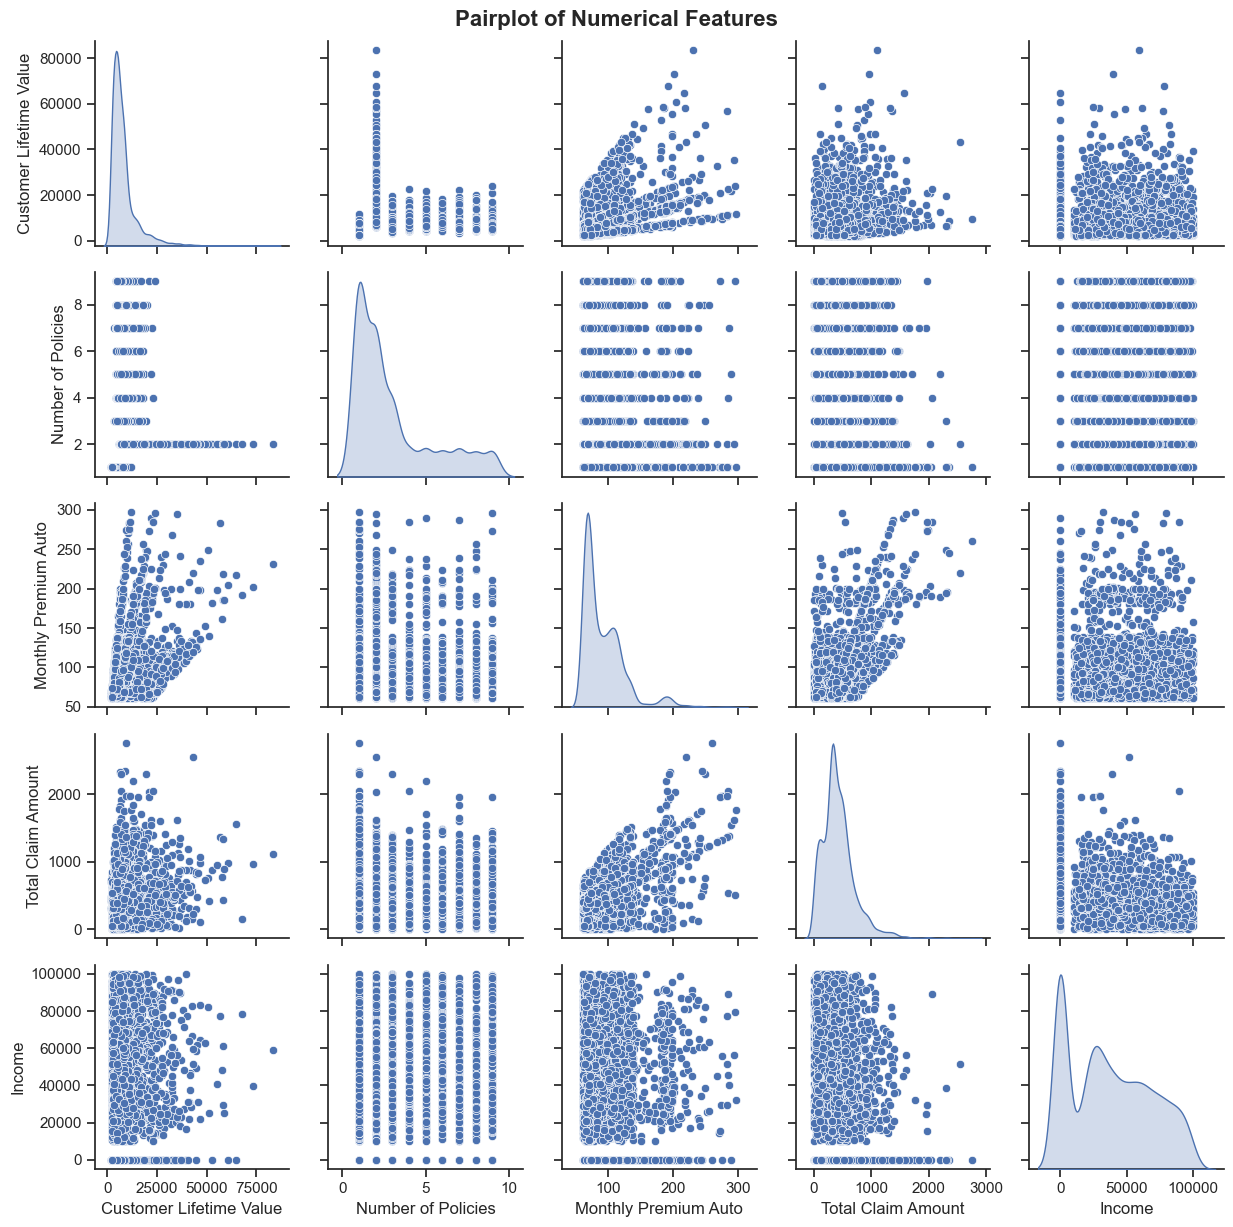

In [205]:
# Scatter plots for all pairs of numerical features

sns.pairplot(df[numerical_features], diag_kind = 'kde')
plt.suptitle('Pairplot of Numerical Features', fontsize = 16, fontweight = 'bold')
plt.tight_layout()
plt.show()

Based on the graph, 
1. **CLV vs `Number of Policies`**<br>
    No clear pattern; points are scattered with some clustering at lower CLV values and 2 policies. The correlation appears weak.
2. **CLV vs `Monthly Premium Auto`**<br>
    A slight positive trend is visible, with higher CLV values associated with higher premiums, especially above 100.
3. **CLV vs `Total Claim Amount`**<br>
    A weak positive trend, with some higher CLV values linked to larger claim amounts (e.g., > 1000).
4. **CLV vs `Income`**<br>
    No discerning pattern; points are widely scattered.
5. **`Number of Policies` vs. Others**<br>
    Little to no relationship with other variables.
6. **`Monthly Premium Auto` vs. `Total Claim Amount`**<br>
    A noticeable positive trend, with higher premiums associated with larger claim amounts.
7. **`Income` vs. `Total Claim Amount`**<br>
    A weak negative trend, with higher incomes linked to lower claim amounts.
8. **Other Pairwise Relationships**<br>
    Generally weak or noisy, indicating limited linear dependencies among predictors.

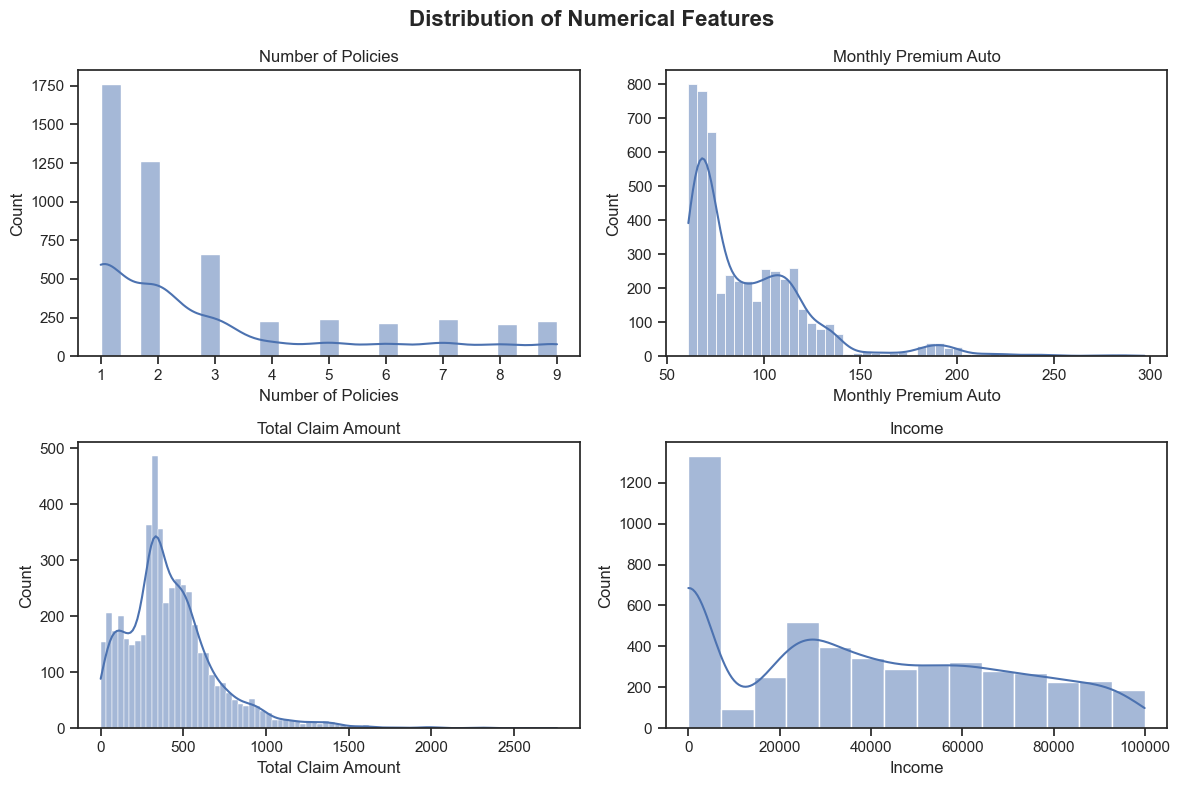

In [206]:
# Distribution Plots of Numerical Features

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df['Number of Policies'], kde=True, ax=axes[0, 0]).set_title('Number of Policies')
sns.histplot(df['Monthly Premium Auto'], kde=True, ax=axes[0, 1]).set_title('Monthly Premium Auto')
sns.histplot(df['Total Claim Amount'], kde=True, ax=axes[1, 0]).set_title('Total Claim Amount')
sns.histplot(df['Income'], kde=True, ax=axes[1, 1]).set_title('Income')

plt.suptitle('Distribution of Numerical Features', fontsize = 16, fontweight = 'bold')
plt.tight_layout()
plt.show()

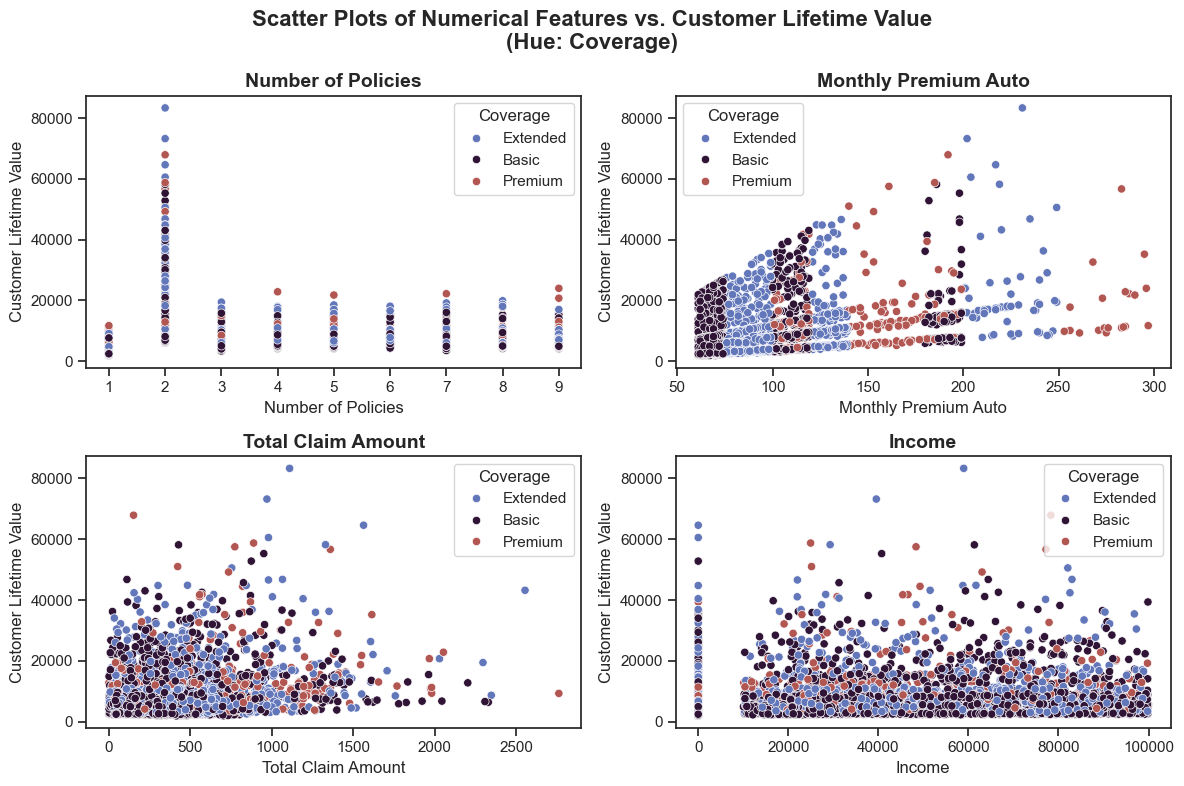

In [207]:
# Scatter Plots of Numerical Features vs. Customer Lifetime Value by Coverage

plt.figure(figsize = (12, 8))
num_subplot = 1

for features in numerical_features2:
    plt.subplot(2, 2, num_subplot)
    sns.scatterplot(data = df, x = features, y = 'Customer Lifetime Value', hue = 'Coverage', palette = 'twilight')
    plt.legend(title = 'Coverage', loc = 'best')
    plt.title(features, size = 14, fontweight = 'bold')
    plt.tight_layout()
    num_subplot += 1

plt.suptitle('Scatter Plots of Numerical Features vs. Customer Lifetime Value\n(Hue: Coverage)', fontsize = 16, fontweight = 'bold')
plt.tight_layout()
plt.show()

To explore the relationships between numerical features and the target variable, Customer Lifetime Value, scatter plots were generated for four key predictors: Number of Policies, Monthly Premium Auto, Total Claim Amount, and Income, with points colored by the customer's Coverage type (Basic, Extended, Premium).

From the plot of Number of Policies, we observe that most customers hold 2 policies, and lifetime value tends to be higher for this group. However, beyond 2 policies, there is no strong linear relationship with the target, and the variation remains relatively wide and flat. The Monthly Premium Auto variable shows a clearer upward trend: as monthly premiums increase, Customer Lifetime Value tends to rise, especially among customers with Extended and Premium coverage—suggesting a possible positive correlation.

The Total Claim Amount also exhibits a similar positive relationship, where higher total claims are generally associated with higher Customer Lifetime Value, though outliers are present. Lastly, the Income variable does not display a clear linear trend with Customer Lifetime Value; the spread remains wide across all income levels, indicating that income might not be a strong direct predictor, or its effect may be captured through interactions or transformed features.

Overall, this visual analysis helps in identifying which numerical features might be more influential and should be prioritized during feature engineering and model development stages.

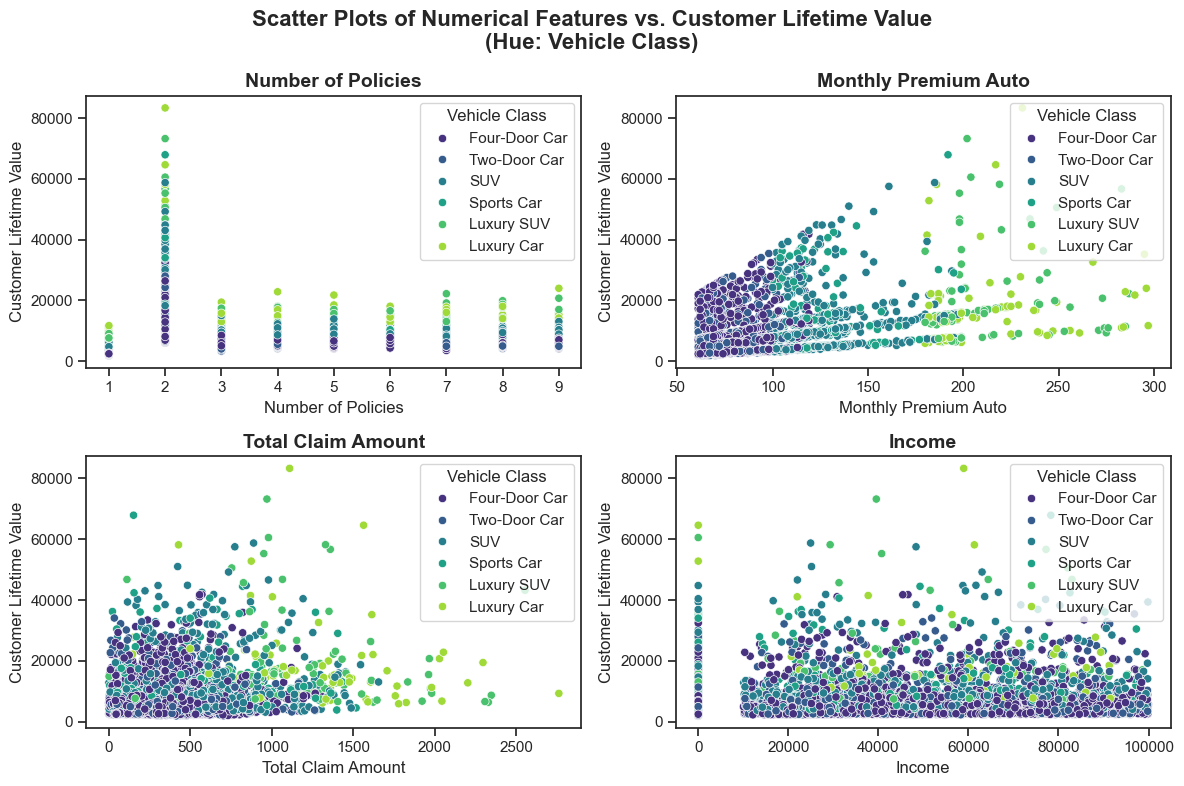

In [208]:
# Scatter Plots of Numerical Features vs. Customer Lifetime Value by Vehicle Class

plt.figure(figsize = (12, 8))
num_subplot = 1

for features in numerical_features2:
    plt.subplot(2, 2, num_subplot)
    sns.scatterplot(data = df, x = features, y = 'Customer Lifetime Value', hue = 'Vehicle Class', palette = 'viridis')
    plt.legend(title = 'Vehicle Class', loc = 'best')
    plt.title(features, size = 14, fontweight = 'bold')
    plt.tight_layout()
    num_subplot += 1

plt.suptitle('Scatter Plots of Numerical Features vs. Customer Lifetime Value\n(Hue: Vehicle Class)', fontsize = 16, fontweight = 'bold')
plt.tight_layout()
plt.show()

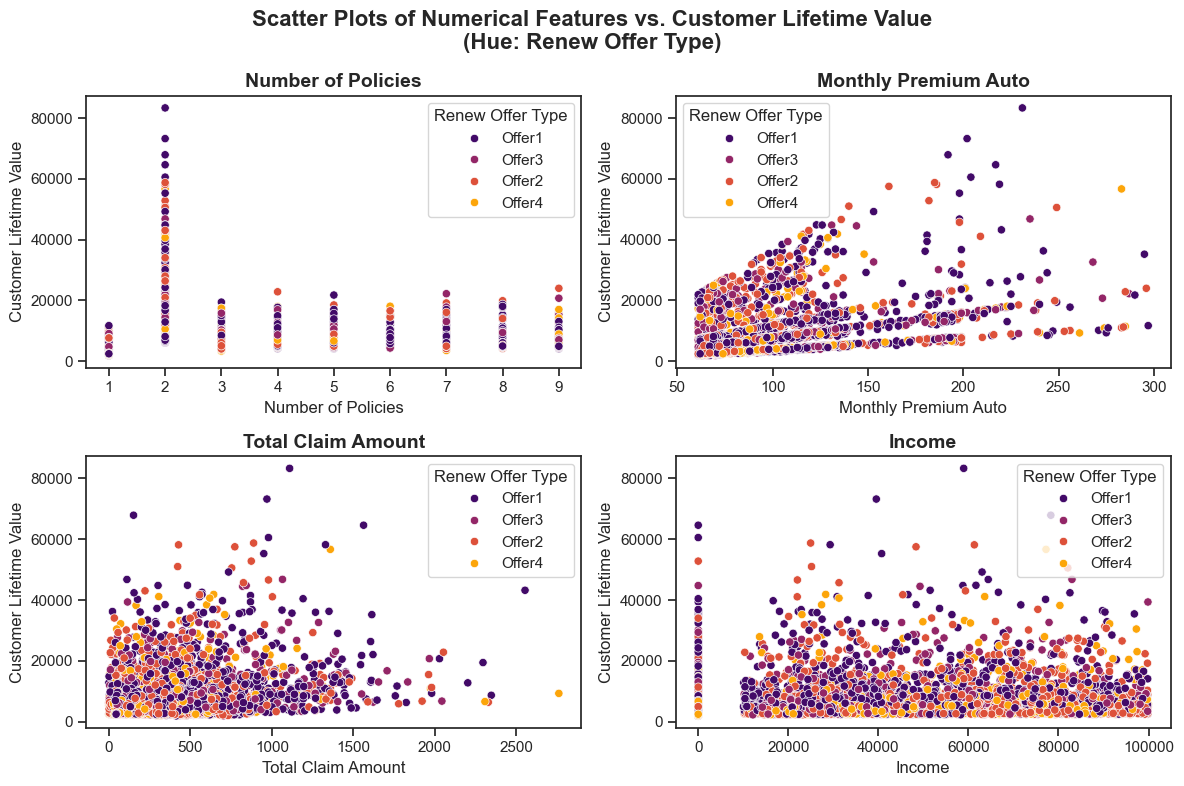

In [209]:
# Scatter Plots of Numerical Features vs. Customer Lifetime Value by Renew Offer Type

plt.figure(figsize = (12, 8))
num_subplot = 1

for features in numerical_features2:
    plt.subplot(2, 2, num_subplot)
    sns.scatterplot(data = df, x = features, y = 'Customer Lifetime Value', hue = 'Renew Offer Type', palette = 'inferno')
    plt.legend(title = 'Renew Offer Type', loc = 'best')
    plt.title(features, size = 14, fontweight = 'bold')
    plt.tight_layout()
    num_subplot += 1

plt.suptitle('Scatter Plots of Numerical Features vs. Customer Lifetime Value\n(Hue: Renew Offer Type)', fontsize = 16, fontweight = 'bold')
plt.tight_layout()
plt.show()

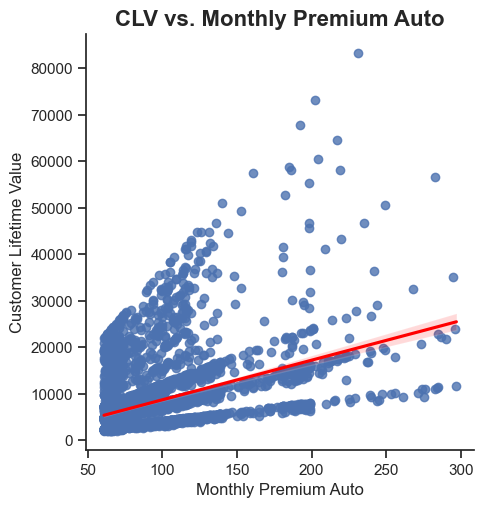

In [210]:
sns.lmplot(data = df, x = 'Monthly Premium Auto', y = 'Customer Lifetime Value', line_kws = {'color': 'red'})

plt.title('CLV vs. Monthly Premium Auto', fontsize = 16, fontweight = 'bold')
plt.show()

Positive trend exists between `Customer Lifetime Value` and `Monthly Premium Auto` where higher monthly premiums resulted in higher CLV.

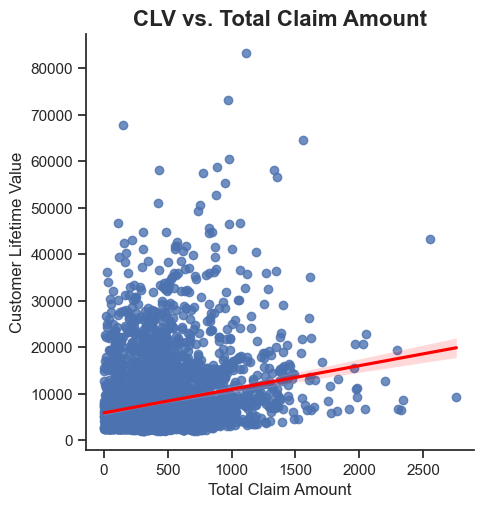

In [211]:
sns.lmplot(data = df, x = 'Total Claim Amount', y = 'Customer Lifetime Value', line_kws = {'color': 'red'})

plt.title('CLV vs. Total Claim Amount', fontsize = 16, fontweight = 'bold')
plt.show()

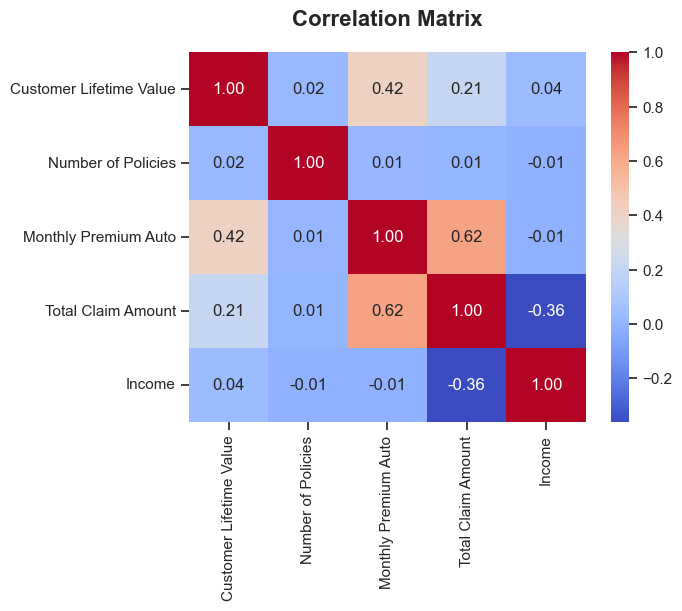

In [212]:
sns.heatmap(df[numerical_features].corr(), annot=True, fmt=".2f", cmap="coolwarm")

plt.title('Correlation Matrix', fontsize = 16, fontweight = 'bold', y = 1.05)
plt.show()

The values present in the correlation matrix represents the Pearson correlation coefficients, which range from -1 to 1 where:
- **1** indicates a perfect positive correlation,
- **-1** indicates a perfect negative correlation,
- **0** indicates no linear correlation.

1. **CLV and `Monthly Premium Auto` (corr = 0.42)**:
    - There is a *moderate positive correlation* between CLV and `Monthly Premium Auto`. This suggests that customers who pay higher monthly premiums for auto insurance tend to have a higher CLV.
    - Higher premiums might reflect more comprehensive coverage or higher-value policies, which could indicate customers with greated engagement or loyalty, leading to a higher lifetime value.
2. **CLV and `Total Claim Amount` (corr = 0.21)**:
    - There is *weak positive correlation* between CLV and `Total Claim Amount`. Customers with higher total claim amounts tend to have slightly higher CLV.
    - This could indivate that customers who file larger or more frequent claims might be more engaged with the insurance provider (e.g., through frequent interactions or longer relationships), potentially increasing their CLV. However, the correlation is weak, so this relationship is not very strong. It might also suggest that high CLV customers are more likely to have more expensive claims (possibly due to more valuable assets or policies), but further investigation is needed to understand causality.
3. **CLV and `Number of Policies` (corr = 0.02)**:
    - There is almost no correlation between CLV and the `Number of Policies`.
    - The number of policies a customer holds does not significantly influence their CLV. This suggests that simply increasing the number of policies a customer has might not directly translate to higher lifetime value. Instead, the type or quality of policies (e.g., higher premiums) might matter more, as seen with the Monthly Premium Auto correlation.
4. **CLV and `Income` (corr = 0.04)**:
    - There is a negligible correlation between CLV and `Income`.
    - A customer’s income level does not appear to have a meaningful linear relationship with their CLV in this dataset. This is somewhat surprising, as one might expect higher-income customers to have greater purchasing power and thus higher CLV, but this data suggests income alone isn’t a strong predictor of CLV.
5. **`Monthly Premium Auto` and `Total Claim Amount` (corr = 0.62)**:
    - This strong positive correlation indicates that customers with higher monthly premiums tend to have higher claim amounts. This makes sense, as higher premiums often correspond to more comprehensive coverage or higher-risk policies, which could lead to larger claims.
    - Since both of these features are positively correlated with CLV (0.40 and 0.22, respectively), they might indirectly explain some of the variation in CLV.
6. **`Total Claim Amount` and `Income` (corr = -0.36)**:
    - There’s a moderate negative correlation between `Total Claim Amount` and `Income`, meaning higher-income customers tend to have lower claim amounts. This could indicate that higher-income customers are less likely to file claims, possibly due to safer behaviors, better risk management, or different policy types.
    - Despite this, `Income` has almost no direct correlation with CLV (0.03), suggesting that the relationship between claim behavior and CLV isn’t strongly mediated by income.

We can conclude that CLV is driven by premiums rather than income.

**Model Considerations**:
- **Linear Regression**: The non-linear and skewed distributions suggest that transforming both CLV and predictors (e.g., Log or Box-Cox) could improve linearity and meet regression assumptions (e.g., normality of residuals, homoscedasticity). However, the noisy scatter plots indicate that linear models might struggle without feature engineering.
- **Non-Linear Models**: Tree-based models (e.g., Random Forest) or gradient boosting could handle the skewness and non-linearities without requiring transformations, potentially outperforming linear regression.

### **Outlier Analysis**

In [213]:
def summarize_outliers(df):
    summary = []
    
    # Select only numerical columns
    num_cols = df.select_dtypes(include=['number']).columns
    
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        extreme_outlier_threshold = df[col].quantile(0.99)  # 99th percentile

        # Identify outliers
        total_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        high_outliers = (df[col] > upper_bound).sum()
        low_outliers = (df[col] < lower_bound).sum()
        extreme_outliers = (df[col] > extreme_outlier_threshold).sum()
        
        # Store results
        summary.append({
            'Feature': col,
            'Total Outliers': total_outliers,
            'Outliers > Upper Bound': high_outliers,
            'Outliers < Lower Bound': low_outliers,
            'Extreme Outliers (> 99th %ile)': extreme_outliers
        })
    
    # Convert to DataFrame
    return pd.DataFrame(summary)

# Run function
outlier_summary = summarize_outliers(df)
outlier_summary

,Feature,Total Outliers,Outliers > Upper Bound,Outliers < Lower Bound,Extreme Outliers (> 99th %ile)
0,Number of Policies,228,228,0,0
1,Monthly Premium Auto,251,251,0,50
2,Total Claim Amount,216,216,0,51
3,Income,0,0,0,51
4,Customer Lifetime Value,449,449,0,51


In [214]:
def label_outliers(df):
    # Select only numerical columns
    num_cols = df.select_dtypes(include=['number']).columns
    
    # Initialize a dictionary to store outlier labels
    outlier_labels = {}
    
    for col in num_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        extreme_outlier_threshold = df[col].quantile(0.99)  # 99th percentile

        # Label outliers (True if outlier, False if not)
        is_outlier = (df[col] < lower_bound) | (df[col] > upper_bound)
        is_extreme_outlier = df[col] > extreme_outlier_threshold

        # Create a combined label: 0 (not outlier), 1 (regular outlier), 2 (extreme outlier)
        outlier_labels[f'{col}_Outlier'] = pd.Series(
            0, index=df.index
        ).where(~is_outlier, 1).where(~is_extreme_outlier, 2)
    
    # Convert to DataFrame
    return pd.DataFrame(outlier_labels)

# Get outlier labels
outlier_df = label_outliers(df)
df_with_outliers = pd.concat([df, outlier_df], axis=1)
print(df_with_outliers)

      Vehicle Class  Coverage Renew Offer Type EmploymentStatus  \
0     Four-Door Car  Extended           Offer1          Retired   
1     Four-Door Car     Basic           Offer1         Employed   
2      Two-Door Car     Basic           Offer1          Retired   
3     Four-Door Car   Premium           Offer3         Disabled   
4      Two-Door Car     Basic           Offer3    Medical Leave   
...             ...       ...              ...              ...   
5663  Four-Door Car     Basic           Offer1         Employed   
5664  Four-Door Car     Basic           Offer4       Unemployed   
5665  Four-Door Car   Premium           Offer1         Employed   
5666  Four-Door Car     Basic           Offer1         Employed   
5668     Luxury SUV     Basic           Offer2         Employed   

     Marital Status             Education  Number of Policies  \
0          Divorced  High School or Below                 2.0   
1           Married               College                 6.0   


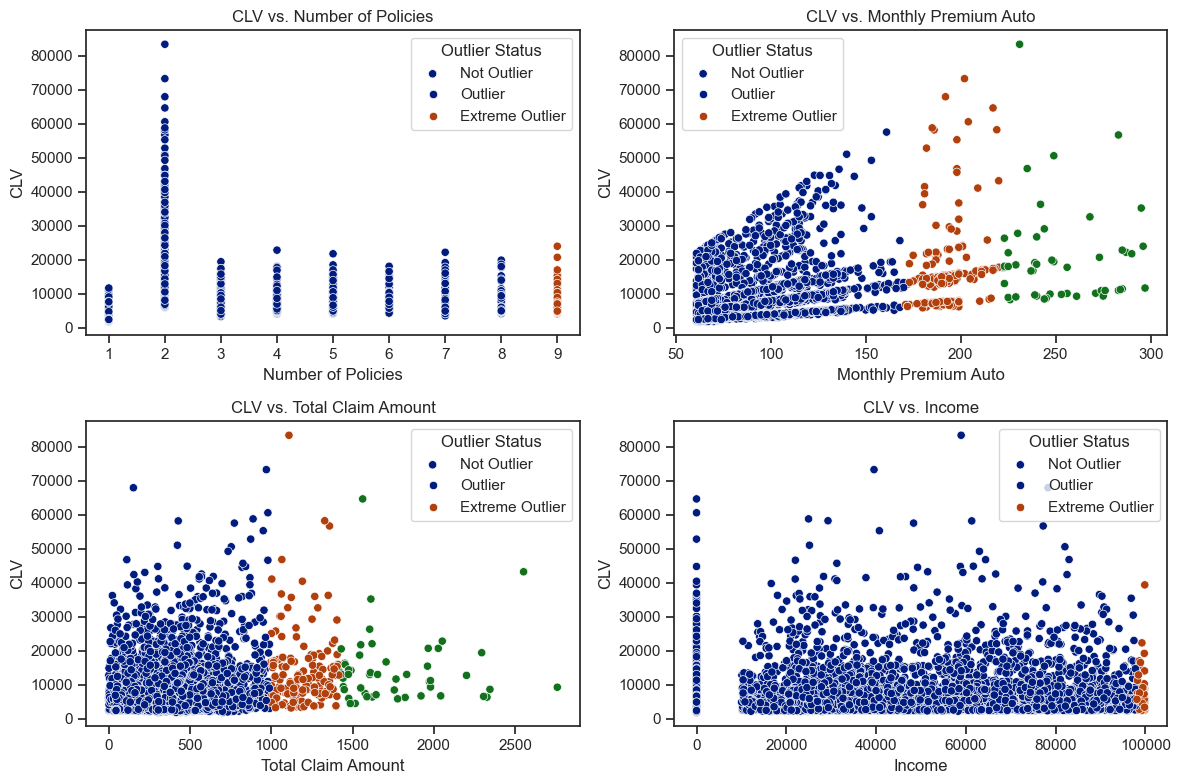

In [215]:
# Numerical features (excluding the target CLV)
num_features = [col for col in df.select_dtypes(include=['number']).columns if col != 'Customer Lifetime Value']

# Number of rows and columns for the subplot grid
n_cols = 2  # Adjust based on your preference
n_rows = (len(num_features) + n_cols - 1) // n_cols  # Ceiling division to fit all features

# Create the subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))
axes = axes.flatten()  # Flatten to easily iterate over

# Plot each feature vs. CLV
for i, feature in enumerate(num_features):
    sns.scatterplot(
        x=df_with_outliers[feature],
        y=df_with_outliers['Customer Lifetime Value'],
        hue = df_with_outliers[f'{feature}_Outlier'],
        palette='dark',  # 0: not outlier, 1: outlier, 2: extreme outlier
        ax=axes[i]
    )
    axes[i].set_title(f'CLV vs. {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('CLV')
    axes[i].legend(title='Outlier Status', labels=['Not Outlier', 'Outlier', 'Extreme Outlier'])

# Remove empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Based on the graph, it shows the presence of outliers. However, the outliers will be retained, as they often represent real and meaningful customer behaviors in the insurance context. For instance, high CLV outliers might indicate our most valuable customers - those who generate significant revenue over time. Removing these outliers would mean losing valuable insights about these segments, potentially leading to a model that doesn't generalize well to a full range of customer behaviors.

Instead of removing outliers, I opted to transform the data for the following reasons:
1. **Reducing Skewness**<br>
    The previous histograms shows the distributions are right-skewed. Thus, applying transformations can help normalize their distribution near to normal distribution, reducing the impact of extreme values without discarding them.
2. **Preserving All Data**<br>
    Transformations allow us to retain all data points, ensuring that our model captures the full spectrum of customer behaviors, including those high-value or high-risk customers represented by outliers.
3. **Improving Model Fit**<br>
    For regression models, transformations help meet assumptions like linearity and homoscedasticity.
4. **Business Relevance**<br>
    Log and sqrt transformations compress large values while expanding smaller ones, which aligns with insurance dynamics—large CLV or claim amounts don’t grow linearly in impact, and this approach reflects that reality.

## **Feature Construction**
Goal is to create powerful predictors for regression using existing features.

New features derived from existing features are:
1. **Premium to Claim Ratio**<br>
    - Ratio of the monthly premium paid for auto insurance to the total claim amount paid over a specific period for a customer. Mathematically, it is expressed as:
    
    $$Premium\:to\:Claim\:Ratio = \frac{Monthly\:Premium\:Auto}{Total\:Claim\:Amount}$$

    - A higher ratio indicated that the premiums collected are large relative to the claims paid, suggesting potential profitability or under-claiming by the customer
    - A lower ratio suggests that claims exceed or are a significat portion of premiums, which could indicate higher risk or unprofitability.
2. **Premium to Income Ratio**<br>
    - The proportion of a customer's income that is allocated to their monthy auto insurance premium. It is calculated as:

    $$Premium\:to\:Income\:Ratio = \frac{Monthly\:Premium\:Auto}{Income}$$

    - A higher ratio indicates that a larger portion of the customer's income is spent on insurance premiums, which might suggest financial strain or a high reliance on insurance coverage.
    - A lower ratio suggests that insurance is a smaller financial burden, potentially indicating higher affordability or under-insurance.
    - This metric can reflect affordability and customer behavior, such as willingness to pay for coverage.
3. **Claims per Policy**<br>
    - Calculates the average claim amount per policy held by a customer, derived as:

    $$Claims\:Per\:Policy = \frac{Total\:Claim\:Amount}{Number\:of\:Policies}$$

    - A higher value indicates that each policy is associated with a larger claim amount, suggesting higher risk or more significant claims per policy.
    - A lower value suggests that claims are distributed across policies with less intensity, potentially indicating lower risk or smaller claims.
    - This metric can highlight the claim burden per policy, which might vary by customer behavior or policy type.
4. **Income per Policy**
    - Measures the average income per policy held by a customer, calculated as:

    $$Income\:Per\:Policy = \frac{Income}{Number\:of\:Policies}$$

    - A higher value indicates that each policy is associated with a higher income level, suggesting that wealthier customers hold fewer policies or that income is more concentrated per policy.
    - A lower value suggests that income is spread across more policies, potentially indicating lower-income customers with multiple policies or higher insurance dependency.
    - This metric can reflect the financial capacity supporting each policy, which might influence premium affordability or CLV.

In [216]:
df['Claim_to_Premium_Ratio'] = df['Total Claim Amount'] / df['Monthly Premium Auto']
df['Premium_to_Income_Ratio'] = (df['Monthly Premium Auto'] * 12) / (df['Income'] + 1)  # Annualized
df['Claims_per_Policy'] = df['Total Claim Amount'] / df['Number of Policies'].replace(0, 1)
df['Income_per_Policy'] = df['Income'] / df['Number of Policies'].replace(0, 1)

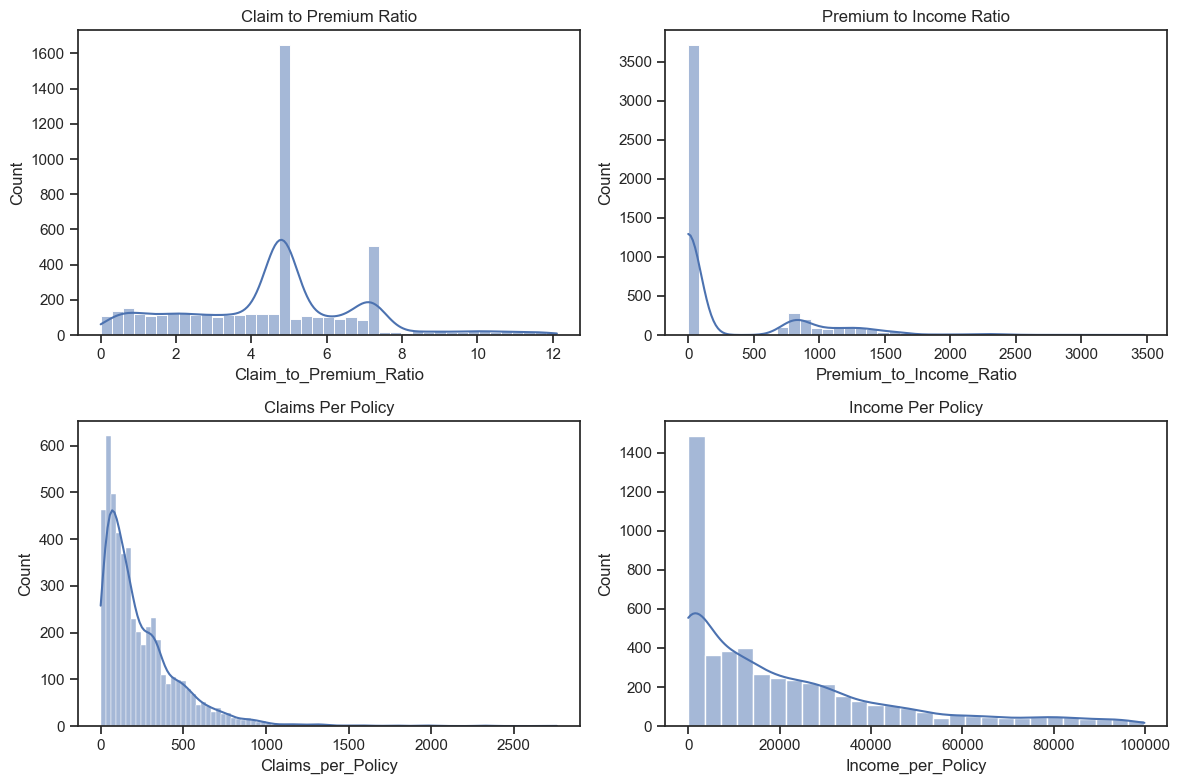

In [217]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(df['Claim_to_Premium_Ratio'], kde=True, ax=axes[0, 0]).set_title('Claim to Premium Ratio')
sns.histplot(df['Premium_to_Income_Ratio'], kde=True, ax=axes[0, 1]).set_title('Premium to Income Ratio')
sns.histplot(df['Claims_per_Policy'], kde=True, ax=axes[1, 0]).set_title('Claims Per Policy')
sns.histplot(df['Income_per_Policy'], kde=True, ax=axes[1, 1]).set_title('Income Per Policy')
plt.tight_layout()
plt.show()

## **Check for Multicollinearity**
Check using both Variance Inflation Factor (VIF) and Principal Component Analysis (PCA)

In [218]:
# Select features (exclude target)
X = df[numerical_features2]

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort by VIF
vif_data = vif_data.sort_values("VIF", ascending=False)
vif_data

,Feature,VIF
1,Monthly Premium Auto,10.717989
2,Total Claim Amount,6.433996
3,Income,2.697575
0,Number of Policies,2.234856


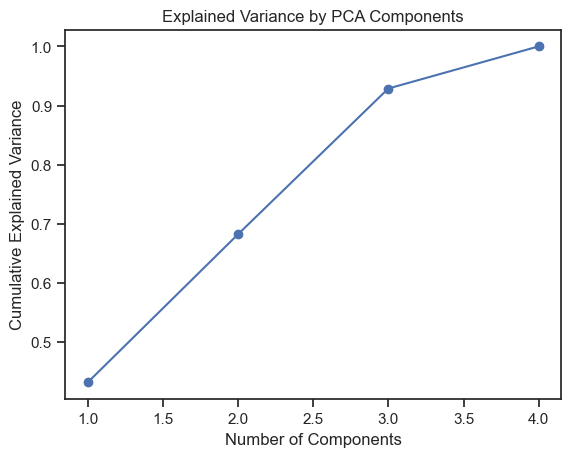

In [219]:
# Separate features and target
X = df[numerical_features2]
y = df['Customer Lifetime Value']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Initialize PCA (start without specifying n_components to explore variance)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Plot explained variance ratio
import matplotlib.pyplot as plt
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.show()

In [220]:
pca = PCA(n_components=4)  # Adjust based on the plot
X_pca = pca.fit_transform(X_scaled)

In [221]:
# Create a DataFrame for loadings
loadings = pd.DataFrame(
    pca.components_.T,  # Transpose to align features as rows
    columns=[f'PC{i+1}' for i in range(pca.n_components_)],
    index=X.columns
)

# Show top features per PC
print(loadings.abs().sort_values(by='PC1', ascending=False))

                           PC1       PC2       PC3       PC4
Total Claim Amount    0.703608  0.029023  0.000464  0.709995
Monthly Premium Auto  0.611140  0.192317  0.462068  0.613201
Income                0.361401  0.307334  0.809406  0.346117
Number of Policies    0.028859  0.931514  0.362429  0.009716


## **Train-Test Split**

In [222]:
X = df.drop(['Customer Lifetime Value', 'Income_Binned'], axis=1)
y = df['Customer Lifetime Value']

In [223]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

##  **Feature Engineering**

### **Transforming Target Variable**

In [224]:
# Applying all transformations to check which one is the best

y = df['Customer Lifetime Value'] # original skewed target variable

# Transformations
y_log = np.log1p(y)               # Log(1 + x)
y_sqrt = np.sqrt(y)               # Square root
y_boxcox, _ = boxcox(y + 1)       # Box-Cox (automated lambda)
y_reciprocal = 1 / (y + 1e-6)     # Reciprocal (handle zeros)

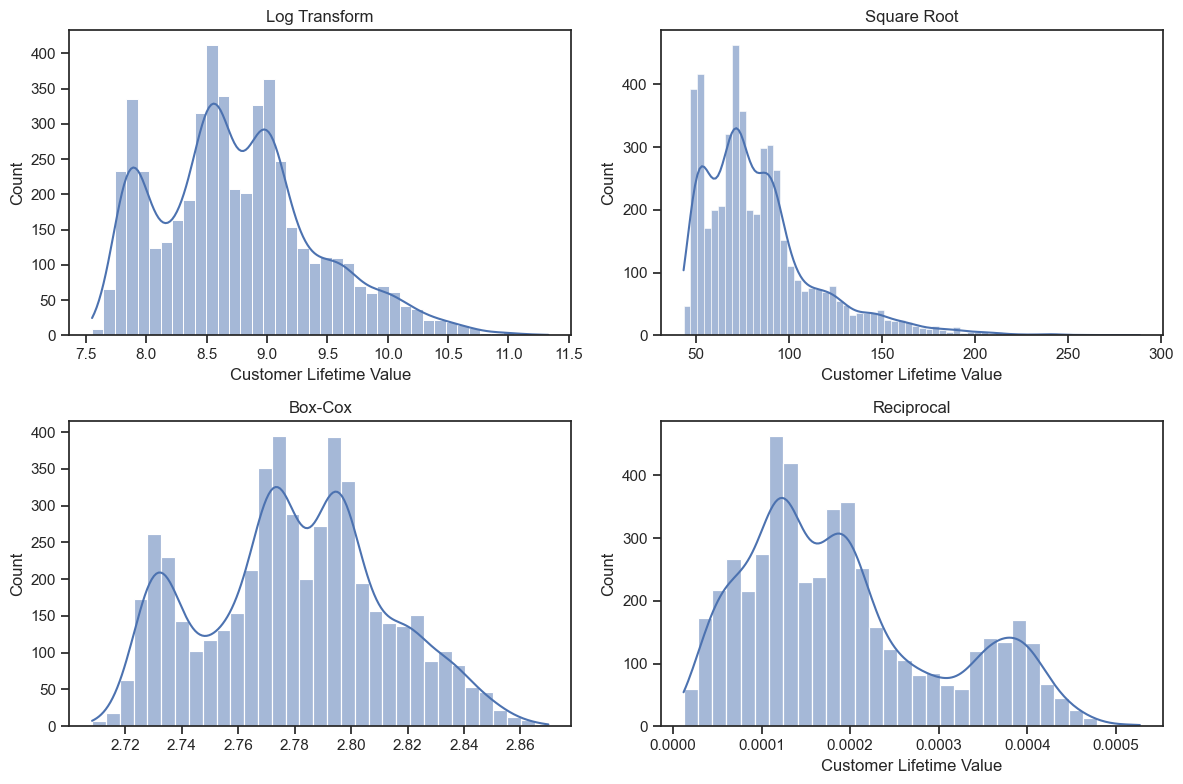

In [225]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
sns.histplot(y_log, kde=True, ax=axes[0, 0]).set_title('Log Transform')
sns.histplot(y_sqrt, kde=True, ax=axes[0, 1]).set_title('Square Root')
sns.histplot(y_boxcox, kde=True, ax=axes[1, 0]).set_title('Box-Cox')
sns.histplot(y_reciprocal, kde=True, ax=axes[1, 1]).set_title('Reciprocal')
plt.tight_layout()
plt.show()

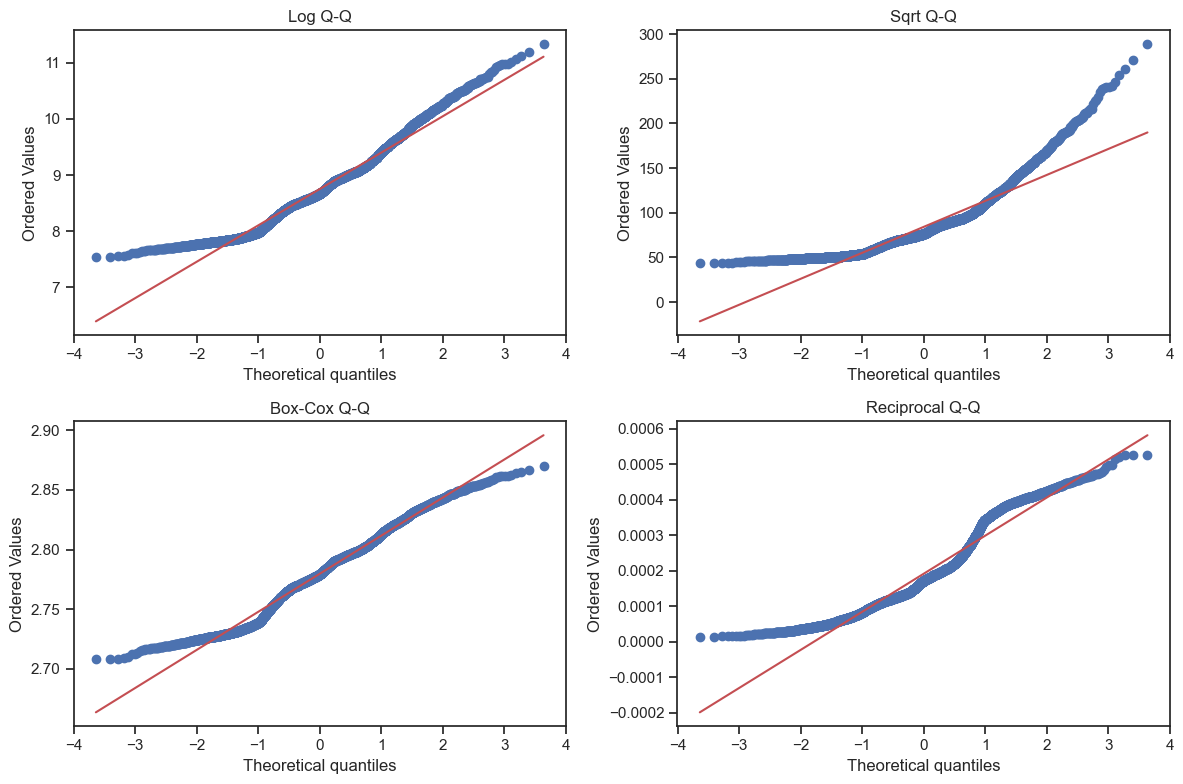

In [226]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
probplot(y_log, plot=axes[0, 0]); axes[0, 0].set_title('Log Q-Q')
probplot(y_sqrt, plot=axes[0, 1]); axes[0, 1].set_title('Sqrt Q-Q')
probplot(y_boxcox, plot=axes[1, 0]); axes[1, 0].set_title('Box-Cox Q-Q')
probplot(y_reciprocal, plot=axes[1, 1]); axes[1, 1].set_title('Reciprocal Q-Q')
plt.tight_layout()
plt.show()

In [227]:
transformations = {
    'Original': y,
    'Log': y_log,
    'Sqrt': y_sqrt,
    'Box-Cox': y_boxcox,
    'Reciprocal': y_reciprocal
}

results = []
for name, transformed_y in transformations.items():
    # Skewness (closer to 0 = more symmetric)
    skewness = skew(transformed_y)
    # Kolmogorov-Smirnov test for normality (p > 0.05 = normal)
    ks_stat, ks_p = kstest(transformed_y, 'norm')
    results.append({
        'Transformation': name,
        'Skewness': skewness,
        'KS p-value': ks_p,
        'Mean': np.mean(transformed_y),
        'Std Dev': np.std(transformed_y)
    })

pd.DataFrame(results)

,Transformation,Skewness,KS p-value,Mean,Std Dev
0,Original,3.112848,0.0,8060.435309,6989.382695
1,Log,0.568318,0.0,8.751976,0.658085
2,Sqrt,1.597155,0.0,84.218789,31.106765
3,Box-Cox,0.044652,0.0,2.779659,0.032224
4,Reciprocal,0.688649,0.0,0.000191,0.000111


Skewness measures the asymmetry of the distribution. A skewness of 0 indicates a perfectly symmetric (normal) distribution, while values greater than 1 or less than -1 suggest significant skewness. Based on the summary we can see:
1. **Log Transformation**<br>
    The log transformation reduces skewness significantly to 0.56, which is much closer to a normal distribution (typically, `|skewness| < 1` is considered acceptable for regression.)
2. **Square Root Transformation**<br>
    The square root transformation reduces skeweness to 1.597, which is an improvement over the original but still indicates moderate skewness.
3. **Box-Cox Transformation**<br>
    The Box-Cox transformation achieves the lowest skewness at 0.045, making the distribution almost perfectly symmetric and very close to normal.
4. **Reciprocal**<br>
    The reciprocal transformation reduces skewness to 0.69, which is better than orignial but not as effective as Log or Box-Cox.

Kolmogorov-Smirniv (KS) test p-value tests whether the transformed data follows a normal distribution. A p-value of 0.0 indicates that none of the transformations result in a distribution that is statistically normal (at a typical significance level of 0.05). This suggests that while skewness is reduced, the transformed distributions still deviate from normality in other ways (e.g., kurtosis, outliers, or multimodal patterns). However, for regression, approximate normality is often sufficient, and the KS test can be overly strict with large datasets. 

Normality matters for linear regression due to the assumptions that the residuals are normally distributed and transforming the target variable to reduce skeweness of a non-normal distribution can help achieve this indirectly by stabilizing variance (homoscedasticity) and making the relationship between predictors and target more linear. Thus, Box-Cox and Log Transfomations are the two winning approaches in this case. 

However, since interpretability is more prioritize in this case, Log Transformation will be applied, as it is easier to explain in a business context and still reduces skewness to an acceptable level.

In [228]:
y_train_transformed = np.log1p(y_train)

### **Encoding and Scaling Pipeline**

In [229]:
numeric_log_features = ['Monthly Premium Auto', 'Total Claim Amount', 'Income', 'Premium_to_Income_Ratio', 'Claims_per_Policy', 'Income_per_Policy']
numeric_sqrt_features = ['Number of Policies', 'Claim_to_Premium_Ratio']
onehot_features = ['Vehicle Class', 'Renew Offer Type', 'EmploymentStatus', 'Marital Status']
ordinal_features = ['Coverage', 'Education']

In [230]:
coverage_order = {'Basic': 0, 'Extended': 1, 'Premium': 2}
education_order = {
    'High School or Below': 0,
    'College': 1, 
    'Bachelor': 2,
    'Master': 3, 
    'Doctor': 4
}

ordinal_mappings = {
    'Coverage': coverage_order,
    'Education': education_order
}

In [231]:
class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, ordinal_mappings):
        self.ordinal_mappings = ordinal_mappings
        
    def fit(self, X, y=None):
        return self  # No fitting needed for predefined mappings
    
    def transform(self, X):
        X = X.copy()
        for col, mapping in self.ordinal_mappings.items():
            X[col] = X[col].map(mapping)
            # Handle unseen categories (optional)
            X[col] = X[col].fillna(-1).astype(int)  
        return X

In [232]:
# Custom Transformers
log_transformer = FunctionTransformer(np.log1p) # Log Transform for right-skewed numeric features
sqrt_transformer = FunctionTransformer(np.sqrt) # Square Root Transform for moderate skews

preprocessor = ColumnTransformer(
    transformers = [
        # Numeric: Log/sqrt -> Scale
        ('numeric_log', Pipeline([
            ('log', log_transformer),
            ('scale', StandardScaler())
        ], verbose = True), numeric_log_features),

        ('numeric_sqrt', Pipeline([
            ('sqrt', sqrt_transformer),
            ('scale', StandardScaler())
        ], verbose = True), numeric_sqrt_features),

        #Categorical: OneHot -> Scale
        ('categorical_onehot', OneHotEncoder(drop = 'first', handle_unknown = 'ignore'), onehot_features),

        ('categorical_ordinal', CustomOrdinalEncoder(ordinal_mappings), ordinal_features)
         
    ],
    remainder = 'passthrough'
)

## **Baseline Model**
Build models using several common regressors and do cross validation, then compare to see which one performs the best.

In [233]:
# Define pipelines for each models
pipelines = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    'ElasticNet': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', ElasticNet())
    ]),
    'Ridge': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Ridge())
    ]),
    'Lasso': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', Lasso())
    ]),
    'KNN': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', KNeighborsRegressor())
    ]),
    'Decision Tree': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', DecisionTreeRegressor())
    ]),
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor())
    ]),
    'Gradient Boosting': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor())
    ]),
    'AdaBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', AdaBoostRegressor())
    ]),
    'SVR': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', SVR())
    ]),
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', XGBRegressor(eval_metric = 'mae'))
    ]),
    'LightGBM': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LGBMRegressor())
    ])
}

In [234]:
# Create a copy of the original pipeline
pipelines_cv = pipelines.copy()

# Replace regularized models with their *CV versions
pipelines_cv['Ridge'] = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RidgeCV(alphas=[0.1, 1.0, 10.0, 100.0], cv=5))
])
pipelines_cv['Lasso'] = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(alphas=[0.01, 0.1, 1.0], cv=5))
])
pipelines_cv['ElasticNet'] = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNetCV(l1_ratio=[0.1, 0.5, 0.9], cv=5))
])

In [235]:
# Benchmark Model (no Cross Validation)
results = []

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train_transformed)
    y_pred = pipe.predict(X_test)
    
    # Inverse transform prediction if needed:
    y_pred_actual = np.expm1(y_pred)
    y_test_actual = y_test.values  # original y_test, not log-transformed

    mae = mean_absolute_error(y_test_actual, y_pred_actual)
    mse = mean_squared_error(y_test_actual, y_pred_actual)
    rmse = root_mean_squared_error(y_test_actual, y_pred_actual)
    mape = mean_absolute_percentage_error(y_test_actual, y_pred_actual)
    r2 = r2_score(y_test_actual, y_pred_actual)

    # Adjusted R² (penalizes irrelevant features)
    n = len(y_test_actual)
    X_test_transformed = preprocessor.fit_transform(X_train)  # Fit on training data
    p = X_test_transformed.shape[1]
    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

    results.append((name, mae, mse, rmse, mape, r2, adjusted_r2))

[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipel

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [236]:
# Benchmark Model (with Outer Cross Validation)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

result_outercv = []

y_log = np.log1p(y)

for name, pipe in pipelines.items():
    # Use cross_val_predict with log-transformed target
    y_pred_log = cross_val_predict(pipe, X, y_log, cv=5)
    
    y_pred_actual = np.expm1(y_pred_log)
    y_true_actual = y.values  # original (not log)

    # Evaluate metrics
    mae = mean_absolute_error(y_true_actual, y_pred_actual)
    mse = mean_squared_error(y_true_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true_actual, y_pred_actual)
    r2 = r2_score(y_true_actual, y_pred_actual)

    # Estimate number of features after preprocessing
    pipe.fit(X_train, y_train_transformed)
    p = pipe.named_steps['preprocessor'].transform(X_test).shape[1]
    n = X.shape[0]

    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

    result_outercv.append((name, mae, mse, rmse, mape, r2, adjusted_r2))

[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.1s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s


[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.1s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipel

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003451 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 4039, number of used features: 24
[LightGBM] [Info] Start training from score 8.752543


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000886 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1708
[LightGBM] [Info] Number of data points in the train set: 4039, number of used features: 24
[LightGBM] [Info] Start training from score 8.749027


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 4039, number of used features: 24
[LightGBM] [Info] Start training from score 8.752473


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1709
[LightGBM] [Info] Number of data points in the train set: 4040, number of used features: 24
[LightGBM] [Info] Start training from score 8.748543


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 4039, number of used features: 24
[LightGBM] [Info] Start training from score 8.755104


In [237]:
# Benchmark Model (with Inner Cross Validation)
cv = KFold(n_splits=5, shuffle=True, random_state=42)

result_innercv = []

y_log = np.log1p(y)

for name, pipe in pipelines_cv.items():
    # Use cross_val_predict with log-transformed target
    y_pred_log = cross_val_predict(pipe, X, y_log, cv=5)
    
    y_pred_actual = np.expm1(y_pred_log)
    y_true_actual = y.values  # original (not log)

    # Evaluate metrics
    mae = mean_absolute_error(y_true_actual, y_pred_actual)
    mse = mean_squared_error(y_true_actual, y_pred_actual)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_true_actual, y_pred_actual)
    r2 = r2_score(y_true_actual, y_pred_actual)

    # Estimate p (number of features after preprocessing)
    preprocessed = pipe.named_steps['preprocessor'].fit(X).transform(X)
    p = preprocessed.shape[1]
    n = X.shape[0]

    adjusted_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

    result_innercv.append((name, mae, mse, rmse, mape, r2, adjusted_r2))

[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.2s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipel

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.826e+01, tolerance: 1.739e-01
  model = cd_fast.enet_coordinate_descent(


[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.119e+01, tolerance: 1.760e-01
  model = cd_fast.enet_coordinate_descent(


[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.703e+01, tolerance: 1.729e-01
  model = cd_fast.enet_coordinate_descent(


[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.486e-01, tolerance: 1.762e-01
  model = cd_fast.enet_coordinate_descent(


[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.449e+02, tolerance: 1.757e-01
  model = cd_fast.enet_coordinate_descent(


[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipel

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1714
[LightGBM] [Info] Number of data points in the train set: 4039, number of used features: 24
[LightGBM] [Info] Start training from score 8.752543


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1708
[LightGBM] [Info] Number of data points in the train set: 4039, number of used features: 24
[LightGBM] [Info] Start training from score 8.749027


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002688 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1711
[LightGBM] [Info] Number of data points in the train set: 4039, number of used features: 24
[LightGBM] [Info] Start training from score 8.752473


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000843 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1709
[LightGBM] [Info] Number of data points in the train set: 4040, number of used features: 24
[LightGBM] [Info] Start training from score 8.748543


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s


Evaluating regression models involves assessing how well the model predicts the continuous target variable based on the input features. Several metrics are commonly used to measure the performance of regression models, each providing different insights into the model's accuracy, error, and fit. Below is a list of the most widely used metrics that will be used in this project:
1. **Mean Absolute Error (MAE)**<br>
    The average of the absolute differences between predicted and actual values.

    $$MAE = \frac{1}{n}\sum_{i=1}^{n}\,\lvert y_i - \hat y_i \rvert$$

    where $y_i$ is the actual value, $\hat y_i$ is the predicted value, and $n$ is the number of observations.

    - Measures the average magnitude of errors in the same unit as the target variable (e.g., dollars for CLV).
    - ***Lower values indicate better performance.***

2. **Mean Squared Error (MSE)**<br>
    The average of the squared differences between predicted and actual values.

    $$MSE = \frac{1}{n}\sum_{i=1}^{n}\,(y_i - \hat y_i)^2$$

    - Penalizes larger errors more heavily due to squaring, giving a sense of the overall error magnitude. 
    - ***Lower values are better.***

3. **Root Mean Squared Error**<br>
    The square root of MSE, bringing the error metric back to the original unit of the target variable.

    $$RMSE = \sqrt{MSE} = \sqrt{\frac{1}{n}\sum_{i=1}^{n}\,(y_i - \hat y_i)^2}$$

    - Represents the standard deviation of the prediction errors
    - ***Lower values are better.***

4. **R-Squared (R<sup>2</sup>)**<br>
    The proportion of variance in the target variable explained by the model.

    $$R^2 = 1 - \dfrac {\sum (y_i - \hat y_i)^2}{\sum (y_i - \bar y)^2}$$

    - Ranges from 0 to 1 (or negative if the model is worse than the mean predictor).
    - ***A value closer to 1 indicates a better fit.***

5. **Adjusted R<sup>2</sup>**<br>
    A modified version of R² that adjusts for the number of predictors in the model.

    $$Adjusted\:R^2 = 1 - \dfrac {(1 - R^2)(n - 1)}{n - k - 1}$$

    where $k$ is the number of predictors.

    - Penalizes the addition of irrelevant predictors, providing a more accurate fit measure for models with multiple features.

6. **Mean Absolute Percentage Error (MAPE)**<br>
    The average of the absolute percentage differences between predicted and actual values.

    $$MAPE = \dfrac{1}{n} \sum_{i=1}^{n}\lvert \dfrac {y_i - \hat y_i}{y_i} \rvert \times 100$$

    - Expressed as a percentage, it shows the average relative error.
    - ***Lower values are better.***

In [238]:
results_base = pd.DataFrame(results, columns=['Model', 'MAE', 'MSE', 'RMSE', 'MAPE', 'R2', 'Adjusted R2']).sort_values('MAE')
results_base

,Model,MAE,MSE,RMSE,MAPE,R2,Adjusted R2
11,LightGBM,1529.087100,1.682708e+07,4102.081877,0.102844,0.682986,0.675262
7,Gradient Boosting,1544.759826,1.773394e+07,4211.167991,0.102010,0.665901,0.657761
6,Random Forest,1550.888500,1.742297e+07,4174.082898,0.104606,0.671760,0.663762
10,XGBoost,1631.996021,1.866990e+07,4320.868279,0.118470,0.648268,0.639698
5,Decision Tree,1863.109228,2.734839e+07,5229.568763,0.135646,0.484770,0.472216
8,AdaBoost,2176.319498,1.811780e+07,4256.501187,0.204294,0.658669,0.650353
9,SVR,2320.132366,3.208319e+07,5664.202623,0.179890,0.395568,0.380841
4,KNN,2711.621728,3.442930e+07,5867.648278,0.287157,0.351369,0.335565
0,Linear Regression,2975.854270,3.544298e+07,5953.400689,0.279648,0.332272,0.316002
2,Ridge,2976.032637,3.560617e+07,5967.090615,0.280733,0.329197,0.312853


In [239]:
results_outercrossval = pd.DataFrame(result_outercv, columns=['Model', 'MAE', 'MSE', 'RMSE', 'MAPE', 'R2', 'Adjusted R2']).sort_values('MAE')
results_outercrossval

,Model,MAE,MSE,RMSE,MAPE,R2,Adjusted R2
7,Gradient Boosting,1575.129829,1.610678e+07,4013.325293,0.107092,0.670291,0.668716
6,Random Forest,1593.771443,1.658002e+07,4071.856575,0.109228,0.660604,0.658982
11,LightGBM,1601.381129,1.664018e+07,4079.237481,0.110392,0.659372,0.657745
10,XGBoost,1683.664664,1.756766e+07,4191.379429,0.123649,0.640386,0.638668
5,Decision Tree,1971.259286,2.944652e+07,5426.464981,0.145898,0.397223,0.394344
8,AdaBoost,2151.250497,1.624241e+07,4030.187155,0.202744,0.667514,0.665926
9,SVR,2343.583351,2.986340e+07,5464.741461,0.185299,0.388690,0.385770
4,KNN,2719.144690,3.298617e+07,5743.358483,0.277690,0.324766,0.321541
2,Ridge,2985.517339,3.308060e+07,5751.573476,0.285972,0.322833,0.319598
0,Linear Regression,2986.152702,3.295176e+07,5740.362048,0.285456,0.325471,0.322248


In [262]:
print(results_outercrossval.head(5))

                Model          MAE           MSE         RMSE      MAPE  \
7   Gradient Boosting  1575.129829  1.610678e+07  4013.325293  0.107092   
6       Random Forest  1593.771443  1.658002e+07  4071.856575  0.109228   
11           LightGBM  1601.381129  1.664018e+07  4079.237481  0.110392   
10            XGBoost  1683.664664  1.756766e+07  4191.379429  0.123649   
5       Decision Tree  1971.259286  2.944652e+07  5426.464981  0.145898   

          R2  Adjusted R2  
7   0.670291     0.668716  
6   0.660604     0.658982  
11  0.659372     0.657745  
10  0.640386     0.638668  
5   0.397223     0.394344  


In [240]:
results_innercrossval = pd.DataFrame(result_innercv, columns=['Model', 'MAE', 'MSE', 'RMSE', 'MAPE', 'R2', 'Adjusted R2']).sort_values('MAE')
results_innercrossval

,Model,MAE,MSE,RMSE,MAPE,R2,Adjusted R2
7,Gradient Boosting,1574.451375,1.609283e+07,4011.586725,0.107050,0.670576,0.669003
6,Random Forest,1592.216571,1.656719e+07,4070.281308,0.109090,0.660866,0.659246
11,LightGBM,1601.381129,1.664018e+07,4079.237481,0.110392,0.659372,0.657745
10,XGBoost,1683.664664,1.756766e+07,4191.379429,0.123649,0.640386,0.638668
5,Decision Tree,1943.227781,2.934680e+07,5417.268904,0.142257,0.399265,0.396395
8,AdaBoost,2158.542065,1.651217e+07,4063.517501,0.200494,0.661992,0.660378
9,SVR,2343.583351,2.986340e+07,5464.741461,0.185299,0.388690,0.385770
4,KNN,2719.144690,3.298617e+07,5743.358483,0.277690,0.324766,0.321541
1,ElasticNet,2984.282097,3.301708e+07,5746.049008,0.285623,0.324133,0.320905
2,Ridge,2985.219824,3.300045e+07,5744.602239,0.285597,0.324474,0.321247


**5-fold cross-validation** was conducted using various regression models to predict the target variable. The results we evaluated using standard regression metrics. The breakdown of the key insights is below:

**Best Performing Models**
| Model              | MAE      | RMSE     | R²    | Notes                                                                |
|--------------------|----------|----------|-------|----------------------------------------------------------------------|
| Gradient Boosting  | 1575.13  | 4013.33  | 0.670 | Best performer; captures non-linear patterns well; lowest errors.    |
| Random Forest      | 1593.77  | 4071.86  | 0.661 | Good ensemble; slightly higher errors than Gradient Boosting.        |
| LightGBM           | 1601.38  | 4079.24  | 0.659 | Efficient boosting; similar to Random Forest; tuning may improve.    |
| XGBoost            | 1683.66  | 4191.38  | 0.640 | Boosting model; higher MAE; needs hyperparameter tuning.             |
| Decision Tree      | 1971.26  | 5426.46  | 0.397 | Worst performer; likely overfitting; high errors due to no ensemble. |

These four models outperformed all others, achieving lowest error rates and highest R<sup>2</sup> scores, suggesting they captured the relationship between features and target relatively well.

**Underperformers**
- *Linear Models (Linear Regression, Ridge, Lasso, ElasticNet)* showed notably higher error rates and lower R<sup>2</sup> scores.
- *Lasso* and *ElasticNet* even produced negative R<sup>2</sup>, indicating their predictions were worse than the mean-based baseline.
- *KNN* and *SVR* also performed poorly, with RMSE > 5000 and low R<sup>2</sup> (< 0.40).
<br>
<br>
> 📌 **Key Takeaways**
> - **Ensemble tree-based models (Boosting variants, Random Forest)** are much better suited for this prediction task.
> - **Gradient Boosting** emerged as the best model across most metrics, including **MAE, RMSE, and R<sup>2</sup>**.
> - While **LightGBM** and **XGBoost** are competitive, **Random Forest** offers a great balance of simplicity and accuracy without requiring GPU or additional tuning out-of-the-box.

In [263]:
models = {
    'Gradient Boosting': GradientBoostingRegressor(),
    'Random Forest': RandomForestRegressor()
}

In [264]:
results_baseline = []

for name, model in models.items():
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

    # Fit on log1p(y_train)
    pipe.fit(X_train, np.log1p(y_train))

    # Predict and reverse transformation
    y_pred_log = pipe.predict(X_test)
    y_pred = np.expm1(y_pred_log)

    # Metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Adjusted R²
    n = X_test.shape[0]
    p = pipe.named_steps['preprocessor'].transform(X_test).shape[1]
    adj_r2 = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

    results_baseline.append((name, mae, mse, rmse, mape, r2, adj_r2))


[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.1s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s


In [265]:
df_baseline = pd.DataFrame(results_baseline, columns=['Model', 'MAE', 'MSE', 'RMSE', 'MAPE', 'R2', 'Adjusted R2'])
df_baseline.reset_index(drop=True, inplace=True)
display(df_baseline)

,Model,MAE,MSE,RMSE,MAPE,R2,Adjusted R2
0,Gradient Boosting,1544.224664,1.772673e+07,4210.312804,0.102035,0.666037,0.657900
1,Random Forest,1546.391608,1.718671e+07,4145.685795,0.103807,0.676211,0.668321


## **Hyperparameter Tuning**
Goal is to tune top 4 models using both `GridSearchCV` and `RandomizedSearchCV` and see which one gives out the best perfomed models.

In [244]:
models = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, verbosity=0),
    "LightGBM": LGBMRegressor(random_state=42)
}

param_grids = {
    "RandomForest": {
        'regressor__n_estimators': [100, 300],
        'regressor__max_depth': [None, 10],
        'regressor__min_samples_split': [2, 5],
    },
    "GradientBoosting": {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.05, 0.1],
        'regressor__max_depth': [3, 5]
    },
    "XGBoost": {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.05, 0.1],
        'regressor__max_depth': [3, 6]
    },
    "LightGBM": {
        'regressor__n_estimators': [100, 200],
        'regressor__learning_rate': [0.05, 0.1],
        'regressor__num_leaves': [31, 50]
    }
}

param_dists = {
    "RandomForest": {
        'regressor__n_estimators': np.arange(100, 501, 100),
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5, 10]
    },
    "GradientBoosting": {
        'regressor__n_estimators': np.arange(100, 401, 100),
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 4, 5]
    },
    "XGBoost": {
        'regressor__n_estimators': np.arange(100, 401, 100),
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__max_depth': [3, 6, 9]
    },
    "LightGBM": {
        'regressor__n_estimators': np.arange(100, 401, 100),
        'regressor__learning_rate': [0.01, 0.05, 0.1],
        'regressor__num_leaves': [31, 50, 70]
    }
}

In [245]:
def search_models(X, y, preprocessor, n_iter=20):
    results = []

    for name in models:
        print(f"\n🔍 Running {name}...")

        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', models[name])
        ])

        grid = GridSearchCV(
            pipeline,
            param_grid=param_grids[name],
            cv=5,
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
            verbose=0
        )

        rand = RandomizedSearchCV(
            pipeline,
            param_distributions=param_dists[name],
            n_iter=n_iter,
            cv=5,
            scoring='neg_mean_absolute_error',
            random_state=42,
            n_jobs=-1,
            verbose=0
        )

        # Fit both
        grid.fit(X, y)
        rand.fit(X, y)

        best_grid_score = -grid.best_score_
        best_rand_score = -rand.best_score_

        # Pick the better model
        best_model = grid.best_estimator_ if best_grid_score < best_rand_score else rand.best_estimator_
        best_score = min(best_grid_score, best_rand_score)
        best_type = 'GridSearch' if best_grid_score < best_rand_score else 'RandomSearch'

        results.append({
            'Model': name,
            'SearchType': best_type,
            'BestMAE': best_score,
            'BestParams': best_model.get_params()
        })

    return results

In [246]:
# y = np.log1p(y) if using log-transformed target
results = search_models(X_train, y_train_transformed, preprocessor)

df_results = pd.DataFrame(results)
print(df_results[['Model', 'SearchType', 'BestMAE']])


🔍 Running RandomForest...
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.1s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.1s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s

🔍 Running GradientBoosting...
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ........

In [247]:
df_results

,Model,SearchType,BestMAE,BestParams
0,RandomForest,RandomSearch,0.107522,"{'memory': None, 'steps': [('preprocessor', Co..."
1,GradientBoosting,GridSearch,0.107204,"{'memory': None, 'steps': [('preprocessor', Co..."
2,XGBoost,RandomSearch,0.107063,"{'memory': None, 'steps': [('preprocessor', Co..."
3,LightGBM,RandomSearch,0.107508,"{'memory': None, 'steps': [('preprocessor', Co..."


In [248]:
best_row = df_results.loc[df_results['BestMAE'].idxmin()]
best_model_name = best_row['Model']
best_search_type = best_row['SearchType']

In [249]:
# Rebuild the model with best params
model_cls = models[best_model_name]  # e.g., RandomForestRegressor()
best_params = best_row['BestParams']

# Extract only the parameters relevant to the regressor
regressor_params = {key.split('__')[-1]: value for key, value in best_params.items() if key.startswith('regressor__')}
model_tuned = model_cls.set_params(**regressor_params)

# Full pipeline with preprocessing
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', model_tuned)
])

# Fit on the full training data
final_pipeline.fit(X_train, y_train_transformed)

[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_log',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scale',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  ['Monthly Premium Auto',
                                                   'Total Claim Amount',
                                                   'Income',
                                                   'Premium_to_Income_Ratio',
                                                   'Claims_per_Policy',
                                                   'Income_per_Policy']),
                                                 ('numeric_sqrt',
                                                  Pipeli...
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=np.int64(100), n_jobs=None,
                              num_parallel_tree=None, ...))])

In [250]:
y_pred = final_pipeline.predict(X_test)
y_pred = np.expm1(y_pred)

In [251]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MAE: {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")
print(f'Test MAPE: {mape:.2f}')
print(f"Test R²: {r2:.4f}")

Test MAE: 1526.25
Test RMSE: 4186.97
Test MAPE: 0.10
Test R²: 0.6697


## **Performance Comparison**

In [252]:
# Result Cross Validation
results_crossval = results_outercrossval.reset_index(drop = True).head(4)
results_crossval

,Model,MAE,MSE,RMSE,MAPE,R2,Adjusted R2
0,Gradient Boosting,1575.129829,1.610678e+07,4013.325293,0.107092,0.670291,0.668716
1,Random Forest,1593.771443,1.658002e+07,4071.856575,0.109228,0.660604,0.658982
2,LightGBM,1601.381129,1.664018e+07,4079.237481,0.110392,0.659372,0.657745
3,XGBoost,1683.664664,1.756766e+07,4191.379429,0.123649,0.640386,0.638668


In [253]:
best_model_name = results_crossval.iloc[0]['Model']
best_model_name

'Gradient Boosting'

C:\Users\Dell\AppData\Local\Temp\ipykernel_37820\2130843021.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_crossval, x='MAE', y='Model', palette='viridis')


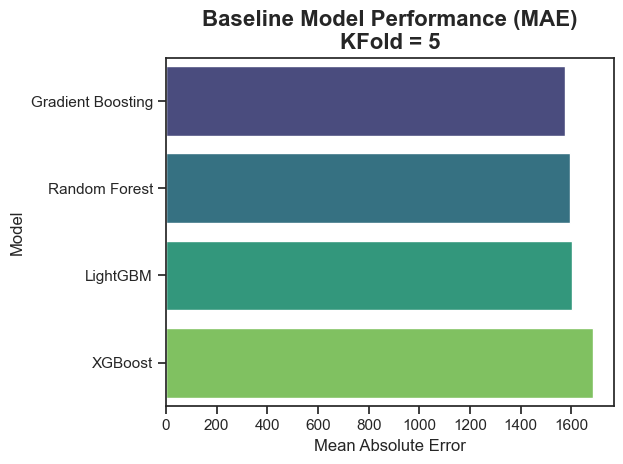

In [254]:
sns.barplot(data=results_crossval, x='MAE', y='Model', palette='viridis')
plt.title('Baseline Model Performance (MAE)\nKFold = 5', fontsize=16, fontweight='bold')
plt.xlabel('Mean Absolute Error')
plt.ylabel('Model')
plt.tight_layout()
plt.show()

In [255]:
print(f"Best Model: {best_model_name} ({best_search_type})")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f'MAPE: {mape:.2f}')
print(f"R²: {r2:.4f}")

Best Model: Gradient Boosting (RandomSearch)
MAE: 1526.25
RMSE: 4186.97
MAPE: 0.10
R²: 0.6697


While hyperparameter tuning often enhances model performance, the Gradient Boosting's default configuration outperformed the tuned version in this case. This indicates that the model's default settings are already well-optimized for this dataset, or the tuning process introduced unnecessary complexity that reduced generalization. Furthermore, cross-validation with a consistent random state revealed a more stable and robust model under default settings.

In [256]:
final_pipeline = pipelines[best_model_name]
final_pipeline.fit(X, y_log)

[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric_log',
                                                  Pipeline(steps=[('log',
                                                                   FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                  ('scale',
                                                                   StandardScaler())],
                                                           verbose=True),
                                                  ['Monthly Premium Auto',
                                                   'Total Claim Amount',
                                                   'Income',
                                                   'Premium_to_Income_Ratio',
                                                   'Claims_per_Policy',
                                                   'Income_per_Policy']),
                                                 ('numeric_sqrt',
                                                  Pipeli...
                                                                handle_unknown='ignore'),
                                                  ['Vehicle Class',
                                                   'Renew Offer Type',
                                                   'EmploymentStatus',
                                                   'Marital Status']),
                                                 ('categorical_ordinal',
                                                  CustomOrdinalEncoder(ordinal_mappings={'Coverage': {'Basic': 0,
                                                                                                      'Extended': 1,
                                                                                                      'Premium': 2},
                                                                                         'Education': {'Bachelor': 2,
                                                                                                       'College': 1,
                                                                                                       'Doctor': 4,
                                                                                                       'High School or Below': 0,
                                                                                                       'Master': 3}}),
                                                  ['Coverage', 'Education'])])),
                ('regressor', GradientBoostingRegressor())])

## **Residual Analysis**

In [258]:
# Example: using best CV model (e.g., Random Forest pipeline)
y_log = np.log1p(y)  # if you've log-transformed y

# Predict using cross_val_predict (this gives out-of-fold predictions)
y_pred_log = cross_val_predict(pipelines['Random Forest'], X, y_log, cv=5)

# Reverse log transform (get back to original scale)
y_pred = np.expm1(y_pred_log)
y_actual = y.values  # original target
residuals = y_actual - y_pred
residuals_percent = residuals / y_actual

# Optionally save for inspection
df_residuals = pd.DataFrame({
    'Actual': y_actual,
    'Predicted': y_pred,
    'Residual': residuals,
    'Residual %': residuals_percent
})

[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] .............. (step 1 of 2) Processing sqrt, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipeline] ............... (step 1 of 2) Processing log, total=   0.0s
[Pipeline] ............. (step 2 of 2) Processing scale, total=   0.0s
[Pipel

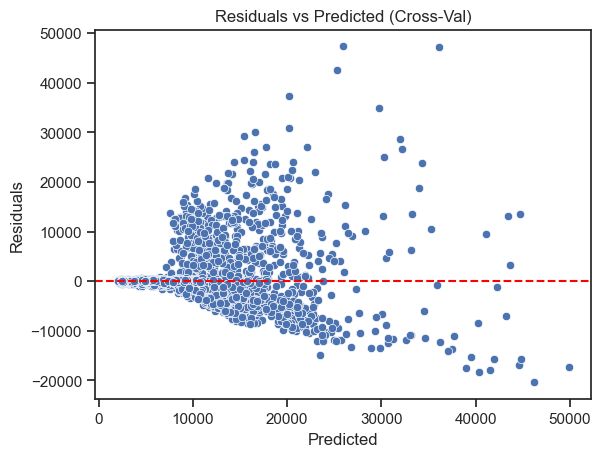

In [259]:
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, linestyle='--', color='red')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted (Cross-Val)")
plt.show()

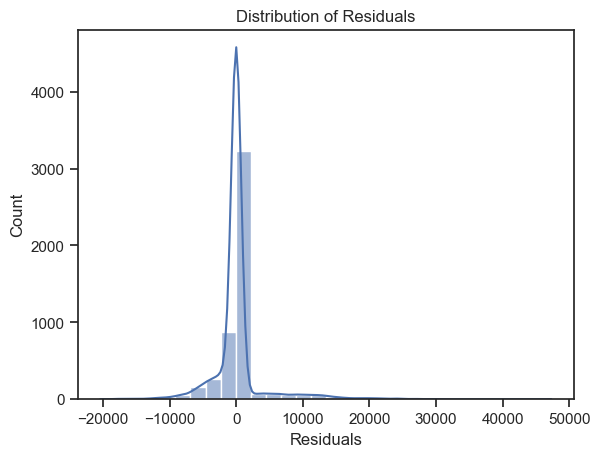

In [260]:
sns.histplot(residuals, kde=True, bins=30)
plt.title("Distribution of Residuals")
plt.xlabel("Residuals")
plt.show()

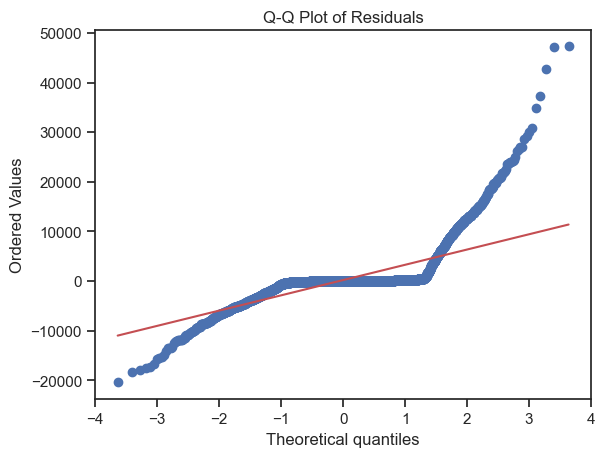

In [261]:
probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.show()

To assess model errors and diagnose potential patterns, residual analysis was conducted using cross-validated predictions. The residuals are centered around zero, which suggests the model has low bias. However, patterns in the residuals vs. predicted plot or deviation from normality in the Q-Q plot may indicate heteroskedasticity or unmodeled nonlinear effects.

## **Conclusion and Recommendations**

### **Conclusion**
#### Data
The dataset, comprising features such as `Monthly_Premium_Auto`, `Total_Claim_Amount`, `Income`, `Coverage`, and `Education`, along with engineered features like `Claims_per_Policy` and `Premium_to_Income_Ratio`, provided a robust foundation for CLV prediction in the insurance sector. Feature engineering, including log transformations (e.g., reducing CLV skewness from 3.06 to 0.56) and square root transformations, effectively mitigated skewness and improved model fit by linearizing relationships (e.g., `Monthly_Premium_Auto` vs. CLV). Ordinal encoding of `Coverage` and `Education` using predefined mappings preserved domain-relevant hierarchies, enhancing interpretability for customer segmentation. Despite these efforts, residual analysis revealed potential heteroskedasticity and unmodeled nonlinear effects, suggesting opportunities for further feature engineering (e.g., interaction terms) or advanced transformations (e.g., Box-Cox for CLV, reducing skewness to 0.045) to capture remaining patterns.

#### Model
Gradient Boosting emerged as the top-performing model with a default configuration, achieving an R² of 0.670, MAE of $1575.13, and RMSE of $4013.33, outperforming other regressors (e.g., Random Forest: R² 0.661, Decision Tree: R² 0.397). Interestingly, hyperparameter tuning did not improve performance, indicating that the default settings were well-suited for this dataset, likely due to the model’s ability to capture non-linear patterns in features like Claims_per_Policy. Cross-validation with a consistent random state confirmed the model’s stability and robustness, with residuals centered around zero, suggesting low bias. However, patterns in the residuals vs. predicted plot and deviations in the Q-Q plot highlight potential heteroskedasticity or unmodeled non-linearities, which could be addressed by ensemble methods (e.g., combining Gradient Boosting with Random Forest) or additional feature engineering to further enhance predictive accuracy.

#### Business
From a business perspective, the Gradient Boosting model provides actionable insights for the insurance company as of May 14, 2025. With an R² of 0.670 and MAPE of 10.7%, the model reliably predicts CLV, enabling effective customer segmentation to identify high-value clients (e.g., those with high Premium_to_Income_Ratio) for targeted retention strategies, supporting premium stability—a key profitability lever. For risk-adjusted pricing, the model’s MAE of $1575 suggests reasonable accuracy but indicates potential pricing errors that could impact profitability; further reducing this error (e.g., through tuning or feature selection) would enhance pricing precision. The model also supports retention strategies by identifying high-value, high-risk customers (e.g., high Claims_per_Policy), allowing for tailored interventions like loyalty discounts. Future work should focus on addressing heteroskedasticity (e.g., via weighted regression) and exploring advanced ensembles to boost performance, ensuring the model drives long-term profitability through optimized pricing and customer retention.

### **Recommendations**
#### Data
- *Enhance Feature Representation*: Investigate adding interaction terms (e.g., `Monthly_Premium_Auto` × `Claims_per_Policy`) or applying a Box-Cox transformation to further reduce CLV skewness (from 0.56 with log to 0.045), addressing residual heteroskedasticity and unmodeled nonlinear effects observed in the analysis.
- **Validate Transformations**: Reassess the effectiveness of log and sqrt transformations on features like `Total_Claim_Amount` and `Premium_to_Income_Ratio` using updated residual plots to ensure optimal preprocessing.

#### Model
- **Ensemble Approach**: Experiment with a VotingRegressor combining Gradient Boosting, Random Forest, and LightGBM to leverage their strengths and mitigate residual patterns (e.g., Q-Q plot deviations).
- **Address Residual Issues**: Implement weighted regression or robust scaling to correct heteroskedasticity and nonlinearity indicated by residual analysis, enhancing model robustness.

### Business
- **Deploy Gradient Boosting**: Roll out the Gradient Boosting model (R²: 0.670, MAPE: 10.7%) for customer segmentation and risk-adjusted pricing, targeting high-value clients and optimizing premium stability.
- **Refine Pricing and Retention**: Use feature importance analysis to select key predictors (e.g., `Monthly_Premium_Auto`, `Claims_per_Policy`) and reduce the $1575 MAE, improving pricing accuracy and retention strategies for high-risk, high-value customers.
- **Future Enhancements**: Plan iterative model updates with advanced ensembles and feature engineering to address residual limitations, ensuring long-term profitability gain

## Save Model

In [257]:
import pickle
import gzip

with gzip.open(f"final_model_{best_model_name}.pkl.gz", "wb") as f:
    pickle.dump(final_pipeline, f)

print(f"✅ Final model '{best_model_name}' saved in compressed format.")

✅ Final model 'Gradient Boosting' saved in compressed format.
